#  Data Science for Business
<font color= blue> CIAPPONI ALESSANDRO 733433</font>\
<font color= blue> CAGNETTA DAVIDE 732521</font>\
<font color= blue>  IMPERIALE MARCO 734486</font>


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pylab as plt 
import seaborn as sns
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Functions Definition

In [3]:
# The p_value is returned to verify Stationarity
def p_value(df_value):
    result = adfuller(df_value.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [4]:
# Corelation and Differencing Plots (1 e 2).
def Differencing_Plot(df_value):  
    
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    axes[0, 0].plot(df_value)
    axes[0, 0].set_title('Original Series')
    plot_acf(df_value, ax=axes[0, 1])

    axes[1, 0].plot(df_value.diff())
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df_value.diff().dropna(), ax=axes[1, 1])

    axes[2, 0].plot(df_value.diff().diff())
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df_value.diff().diff().dropna(), ax=axes[2, 1])

    fig.tight_layout()
    return plt.show()

In [5]:
def Model_Creation(parTrain, parMax_p, parMax_q, parSeasonal):
    model = auto_arima(   parTrain,
                          start_p = 0,
                          start_q = 0,
                          information_criterion = 'aic',
                          test = 'adf',
                          max_p = parMax_p,
                          max_q = parMax_q,
                          D = 1,
                          start_P = 0,
                          m = 12,
                          seasonal = parSeasonal,
                          trace = True,
                          error_action = "ignore",
                          suppress_warnings = True,
                          stepwise = True,
                          verbose = 1)
    return model.summary()

In [6]:
# Allows you to perform the study using SARIMAX
# Moreover a what if analysis between test data and prediction is introduced 
# A1: First element for the order of arima
# A2: Second element for the order of arima
# A3: Third element for the order of arima
# S1: First element for Sarima's order
# S2: Second element for Sarima's order
# S3: Third element for the order of Sarima

def Sarimax_Execution(parTrain,parTest,parColumn,parSteps,A1,A2,A3,S1,S2,S3,parSeason):
  
    # Model Built
    model = SARIMAX(parTrain, order=(A1,A2,A3), seasonal_order=(S1,S2,S3,parSeason))
    
    # Fitting model
    results = model.fit()
    
    # Plot parameters
    plt.rcParams['figure.figsize'] = 12, 8
    plot = results.plot_diagnostics()

    # SARIMA - Prevision with Confidence Intervall
    forecast = results.get_forecast(steps = parSteps)
    lower = forecast.conf_int()["lower " + parColumn]
    upper = forecast.conf_int()["upper " + parColumn]
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    plt.plot(parTrain, label='original',c='b')
    plt.plot(forecast.predicted_mean, label='SARIMAX', c="g")
    plt.plot(parTest, label='test',color='orange')
    plt.fill_between(forecast.conf_int().index,lower,upper,color='lightgray')
    plt.xlabel('Date')
    plt.ylabel('No of activated conracts')
    plt.legend()
    plt.show()

    return forecast

# Goal

Our data analysis project was carried out by studying the labor market of the provinces of Milano and Sondrio in a time interval defined from 2008 to 2021.

We initially concentrated the research on the last year surveyed, analyzing the overall scenario of the provinces of Lombardy on the basis of various aspects such as gender distribution, different types of contracts and employee qualifications.

The Dataset was subsequently reduced to only the two provinces of interest, dedicating the study only to the years in which the Covid pandemic destroyed the economy to find out if there had been drops in hiring or an increase in layoffs in the economic sectors taken into consideration.

Subsequently, the main observation point focused on the implementation of the Time Series with data referring to the last 14 years, comparing the forecasts of a statistical model, such as SARIMA, with one of Machine Learning, LSTM.


# PreAnalysis
In this first phase we wanted to carry out an exploratory analysis to obtain information regarding the datasets relating to the types of work activated, terminated, extended and transformed. So we merged the 4 datasets by eliminating the null values and taking only the 2021 records.

# Time Series PreAnalysis
Continuing with the analysis, we realized that in order to best achieve our goal it was necessary to perform another clean-up of the datasets. Therefore, we have focused only on 'Rapporti_di_lavoro_attivati.csv' and 'Rapporti_di_lavoro_cessati.csv', where we eliminated the null and duplicates values selecting only the records of the two provinces from 2008 to 2021. Moreover, we have mapped the economic sector column in both datasets into numerical data, using the scale_mapper.

In [7]:
activated_jobs = pd.read_csv('Rapporti_di_lavoro_attivati.csv')
#lavori_attivati.head()

## Cleaning Activated Jobs DataSet

In [8]:
activated_jobs_2 = activated_jobs.copy()

In [9]:
# Drop duplicates values
activated_jobs_2 = activated_jobs.drop_duplicates()

In [10]:
# Drop Null values
activated_jobs_2 = activated_jobs.dropna()

In [11]:
activated_jobs_2["TIPO"] = "ATTIVATO"

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_15400/2633408259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activated_jobs_2["TIPO"] = "ATTIVATO"


In [12]:
# Only two Provinces from Dataset are selected
activated_jobs_2 = activated_jobs_2.loc[(activated_jobs_2['PROVINCIAIMPRESA'] == 'MILANO') |
                                        (activated_jobs_2['PROVINCIAIMPRESA'] == 'SONDRIO')]

## Fixing Year Range

In [13]:
activated_jobs_3 = activated_jobs_2.copy()

In [14]:
# Transformation column DATA from object to datetime
activated_jobs_3['DATA'] = pd.to_datetime(activated_jobs_3['DATA'])

In [15]:
# Rename column NAZIONE 
activated_jobs_3['NAZIONE'] = activated_jobs_3['ITALIANO']
activated_jobs_3 = activated_jobs_3.drop(['ITALIANO'], axis = 1)

In [16]:
activated_jobs_3.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
TIPO                                 object
NAZIONE                              object
dtype: object

In [17]:
# Creation column ANNO to select specific interval times 
activated_jobs_3['ANNO'] = activated_jobs_3.DATA.dt.year

In [18]:
# Time interval expressed in ANNO  
interval_year = (activated_jobs_3['ANNO'] > 2007) & (activated_jobs_3['ANNO'] <= 2021)
activated_jobs_3 = activated_jobs_3.loc[interval_year]

## Transformation

In [19]:
#Searching different type of the Economic Sector
activated_jobs_3.groupby('SETTOREECONOMICODETTAGLIO').SETTOREECONOMICODETTAGLIO.count().sort_values(ascending=False).head(9)

SETTOREECONOMICODETTAGLIO
Attività di produzione cinematografica, di video e di programmi televisivi         372356
Alberghi                                                                           360440
Altri servizi di supporto alle imprese nca                                         217703
Ristorazione con somministrazione                                                  213443
Attività di famiglie e convivenze come datori di lavoro per personale domestico    169954
Pulizia generale (non specializzata) di edifici                                    132111
Commercio al dettaglio di confezioni per adulti                                    129228
Costruzione di edifici residenziali e non residenziali                             114645
Istruzione secondaria di primo grado: scuole medie                                  85270
Name: SETTOREECONOMICODETTAGLIO, dtype: int64

In [20]:
#Obtained data are mapped to associate different values to first 9 categories
scale_mapper = {'Alberghi': 0, 
                'Attività di produzione cinematografica, di video e di programmi televisivi': 1,
                'Ristorazione con somministrazione': 2,
                'Altri servizi di supporto alle imprese nca': 3,
                'Attività di famiglie e convivenze come datori di lavoro per personale domestico': 4,
                'Pulizia generale (non specializzata) di edifici': 5,
                'Commercio al dettaglio di confezioni per adulti': 6,
                'Costruzione di edifici residenziali e non residenziali': 7,
                'Istruzione secondaria di primo grado: scuole medie': 8,
               }

In [21]:
#New column containing related integer values is created
activated_jobs_3['SETTOREECONOMICO'] = activated_jobs_3['SETTOREECONOMICODETTAGLIO'].replace(scale_mapper)
activated_jobs_3 = activated_jobs_3.apply(lambda row: row[activated_jobs_3['SETTOREECONOMICO'].isin([0,1,2,3,4,5,6,7,8])])
activated_jobs_3.SETTOREECONOMICO.unique()

array([4, 7, 8, 3, 2, 6, 5, 0, 1], dtype=object)

In [22]:
################################################################################################################################

# Analysis
The analysis phase was divided into two parts. In the first part, starting from the 4 combined data sets, we have visualized the academic qualifications and contracts of the two provinces for the year 2021. In the second part we only dealt with hires and layoffs between 2019 and 2021.

In [23]:
Labor_Market_ds = pd.read_csv('Labor_Market_Data_Cleaning.csv')

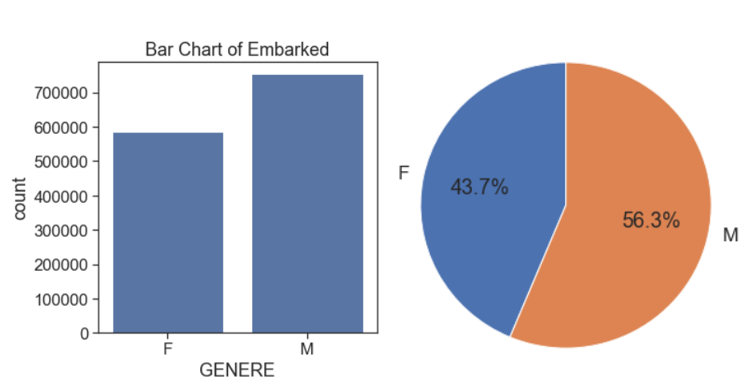

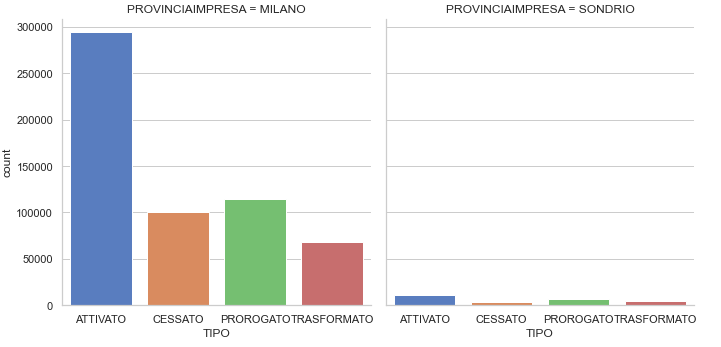

In [24]:
#Creation of a small dataset containing two main provinces 
Tre_Province = Labor_Market_ds[(Labor_Market_ds['PROVINCIAIMPRESA'] == 'MILANO')|
                               (Labor_Market_ds['PROVINCIAIMPRESA'] == 'SONDRIO')]
Tre_Province = Tre_Province.reset_index(drop=True)
Tre_Province.groupby('PROVINCIAIMPRESA').PROVINCIAIMPRESA.count()

PROVINCIAIMPRESA
MILANO     577997
SONDRIO     25526
Name: PROVINCIAIMPRESA, dtype: int64

# Milano

### Titolo di Studio
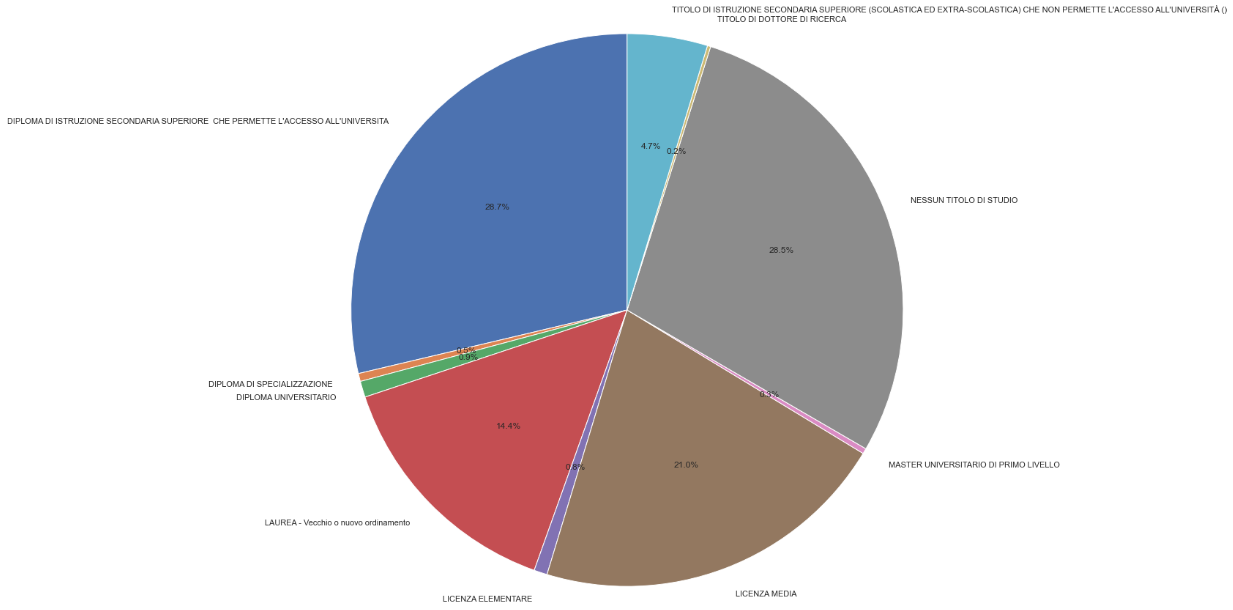

### Contratto di Lavoro
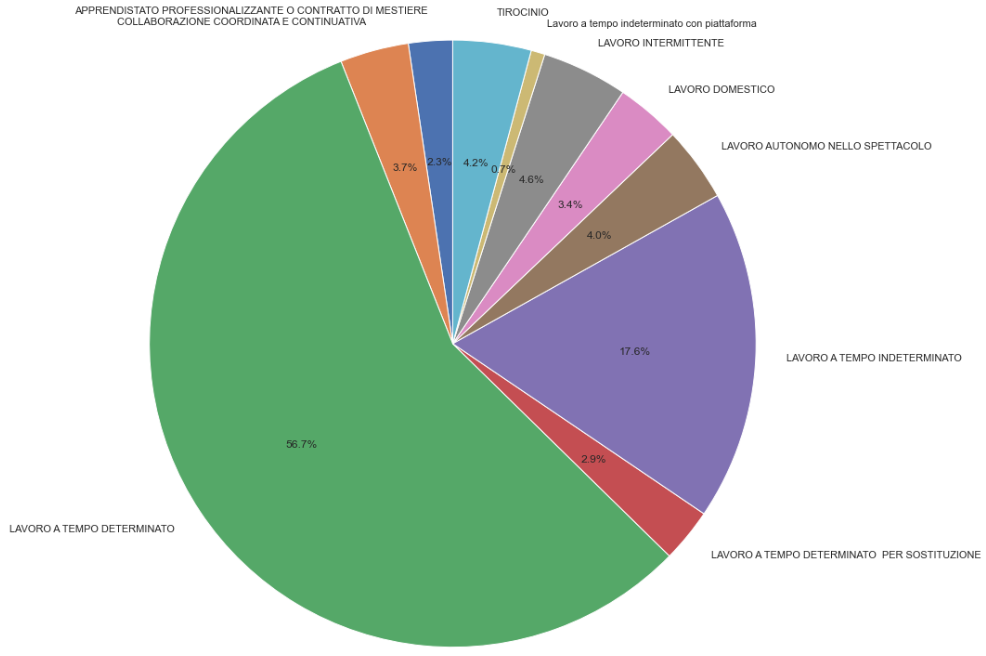

## Analisys Assumptions and Dismissals

In [25]:
Assumptions_Milano = pd.read_csv('Lavori_Attivati_Cleaning.csv')
Dismissals_Milano = pd.read_csv('Lavori_Cessati_Cleaning.csv')

In [26]:
# Changing Type of DATA and SETTOREECONOMICO columns
Assumptions_Milano = Assumptions_Milano.loc[(Assumptions_Milano['PROVINCIAIMPRESA'] == 'MILANO')]
Assumptions_Milano['DATA'] = pd.to_datetime(Assumptions_Milano['DATA'])
Assumptions_Milano['SETTOREECONOMICO'] = pd.to_numeric(Assumptions_Milano['SETTOREECONOMICO'])

Dismissals_Milano = Dismissals_Milano.loc[(Dismissals_Milano['PROVINCIAIMPRESA'] == 'MILANO')]
Dismissals_Milano['DATA'] = pd.to_datetime(Dismissals_Milano['DATA'])
Dismissals_Milano['SETTOREECONOMICO'] = pd.to_numeric(Dismissals_Milano['SETTOREECONOMICO'])

In [27]:
# Time Interval is selected for Assumptions
interval_year = (Assumptions_Milano['ANNO'] > 2018) & (Assumptions_Milano['ANNO'] <= 2021)
Assumptions_Milano = Assumptions_Milano.loc[interval_year]

In [28]:
# Time Interval is selected for Dismissals
interval_year = (Dismissals_Milano['ANNO'] > 2018) & (Dismissals_Milano['ANNO'] <= 2021)
Dismissals_Milano = Dismissals_Milano.loc[interval_year]

In [29]:
# Rebuilding the DataSets
Assumptions_Milano = Assumptions_Milano[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA', 'TIPO']]
Dismissals_Milano = Dismissals_Milano[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA', "TIPO"]]

In [30]:
Assumptions_Milano = Assumptions_Milano.groupby(["SETTOREECONOMICODETTAGLIO","SETTOREECONOMICO"]).count()
Assumptions_Milano

DATA  \
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO           
Alberghi                                           0                  41210   
Altri servizi di supporto alle imprese nca         3                  27173   
Attività di famiglie e convivenze come datori d... 4                  47768   
Attività di produzione cinematografica, di vide... 1                 101335   
Commercio al dettaglio di confezioni per adulti    6                  30085   
Costruzione di edifici residenziali e non resid... 7                  23356   
Istruzione secondaria di primo grado: scuole medie 8                  22220   
Pulizia generale (non specializzata) di edifici    5                  37700   
Ristorazione con somministrazione                  2                  49487   

                                                                     PROVINCIAIMPRESA  \
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO                     
Alberghi                                           0                            41210   
Altri servizi di supporto alle imprese nca         3                            27173   
Attività di famiglie e convivenze come datori d... 4                            47768   
Attività di produzione cinematografica, di vide... 1                           101335   
Commercio al dettaglio di confezioni per adulti    6                            30085   
Costruzione di edifici residenziali e non resid... 7                            23356   
Istruzione secondaria di primo grado: scuole medie 8                            22220   
Pulizia generale (non specializzata) di edifici    5                            37700   
Ristorazione con somministrazione                  2                            49487   

                                                                       TIPO  
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO          
Alberghi                                           0                  41210  
Altri servizi di supporto alle imprese nca         3                  27173  
Attività di famiglie e convivenze come datori d... 4                  47768  
Attività di produzione cinematografica, di vide... 1                 101335  
Commercio al dettaglio di confezioni per adulti    6                  30085  
Costruzione di edifici residenziali e non resid... 7                  23356  
Istruzione secondaria di primo grado: scuole medie 8                  22220  
Pulizia generale (non specializzata) di edifici    5                  37700  
Ristorazione con somministrazione                  2                  49487

In [31]:
Dismissals_Milano = Dismissals_Milano.groupby(["SETTOREECONOMICODETTAGLIO","SETTOREECONOMICO"]).count()
Dismissals_Milano

DATA  \
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO          
Alberghi                                           0                  5025   
Altri servizi di supporto alle imprese nca         3                 11846   
Attività di famiglie e convivenze come datori d... 4                 32101   
Attività di produzione cinematografica, di vide... 1                  1714   
Commercio al dettaglio di confezioni per adulti    6                  2894   
Costruzione di edifici residenziali e non resid... 7                 12738   
Istruzione secondaria di primo grado: scuole medie 8                   826   
Pulizia generale (non specializzata) di edifici    5                 17465   
Ristorazione con somministrazione                  2                 20915   

                                                                     PROVINCIAIMPRESA  \
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO                     
Alberghi                                           0                             5025   
Altri servizi di supporto alle imprese nca         3                            11846   
Attività di famiglie e convivenze come datori d... 4                            32101   
Attività di produzione cinematografica, di vide... 1                             1714   
Commercio al dettaglio di confezioni per adulti    6                             2894   
Costruzione di edifici residenziali e non resid... 7                            12738   
Istruzione secondaria di primo grado: scuole medie 8                              826   
Pulizia generale (non specializzata) di edifici    5                            17465   
Ristorazione con somministrazione                  2                            20915   

                                                                      TIPO  
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO         
Alberghi                                           0                  5025  
Altri servizi di supporto alle imprese nca         3                 11846  
Attività di famiglie e convivenze come datori d... 4                 32101  
Attività di produzione cinematografica, di vide... 1                  1714  
Commercio al dettaglio di confezioni per adulti    6                  2894  
Costruzione di edifici residenziali e non resid... 7                 12738  
Istruzione secondaria di primo grado: scuole medie 8                   826  
Pulizia generale (non specializzata) di edifici    5                 17465  
Ristorazione con somministrazione                  2                 20915

In [32]:
# Join implementation to obtain the Counter values of hired and fired people
Combination = Assumptions_Milano.merge(Dismissals_Milano, on = "SETTOREECONOMICODETTAGLIO", how = "inner")
Combination["ATTIVATO"]= Combination["TIPO_x"]
Combination = Combination.drop(["DATA_x","TIPO_x","PROVINCIAIMPRESA_x"], axis = 1)
Combination["CESSATO"]= Combination["TIPO_y"]
Combination = Combination.drop(["DATA_y","TIPO_y","PROVINCIAIMPRESA_y"], axis = 1)
Combination

ATTIVATO  CESSATO
SETTOREECONOMICODETTAGLIO                                            
Alberghi                                               41210     5025
Altri servizi di supporto alle imprese nca             27173    11846
Attività di famiglie e convivenze come datori d...     47768    32101
Attività di produzione cinematografica, di vide...    101335     1714
Commercio al dettaglio di confezioni per adulti        30085     2894
Costruzione di edifici residenziali e non resid...     23356    12738
Istruzione secondaria di primo grado: scuole medie     22220      826
Pulizia generale (non specializzata) di edifici        37700    17465
Ristorazione con somministrazione                      49487    20915

### Assumptions Plot

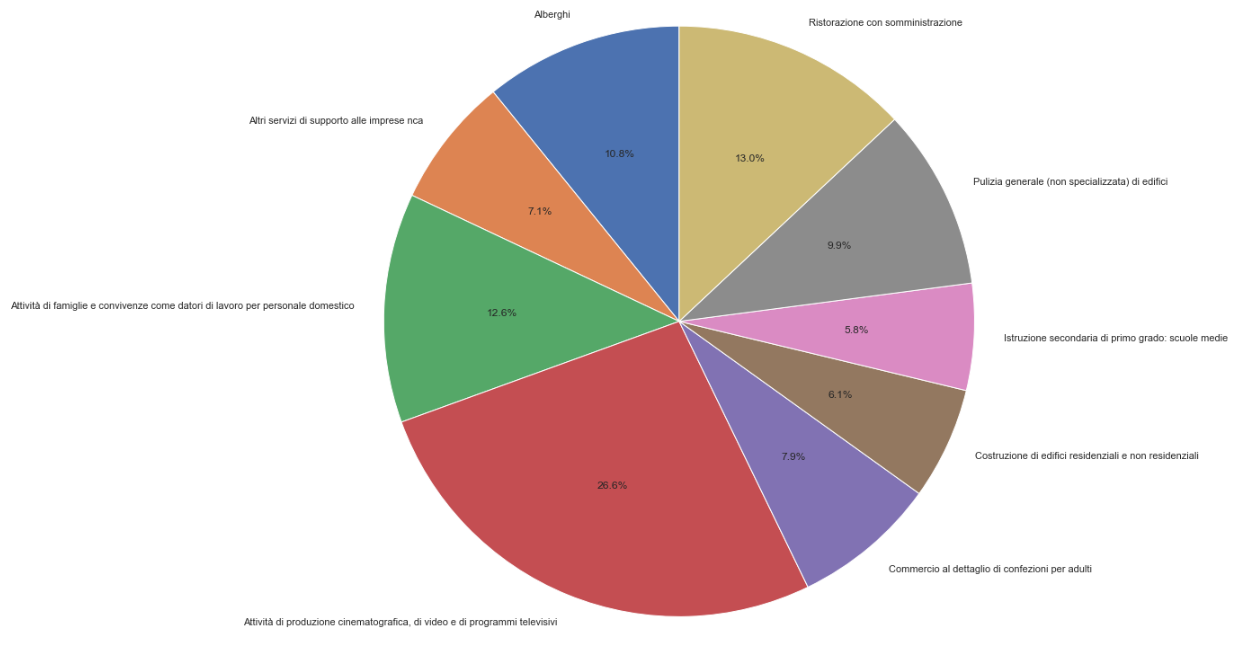

### Dismissals Plot

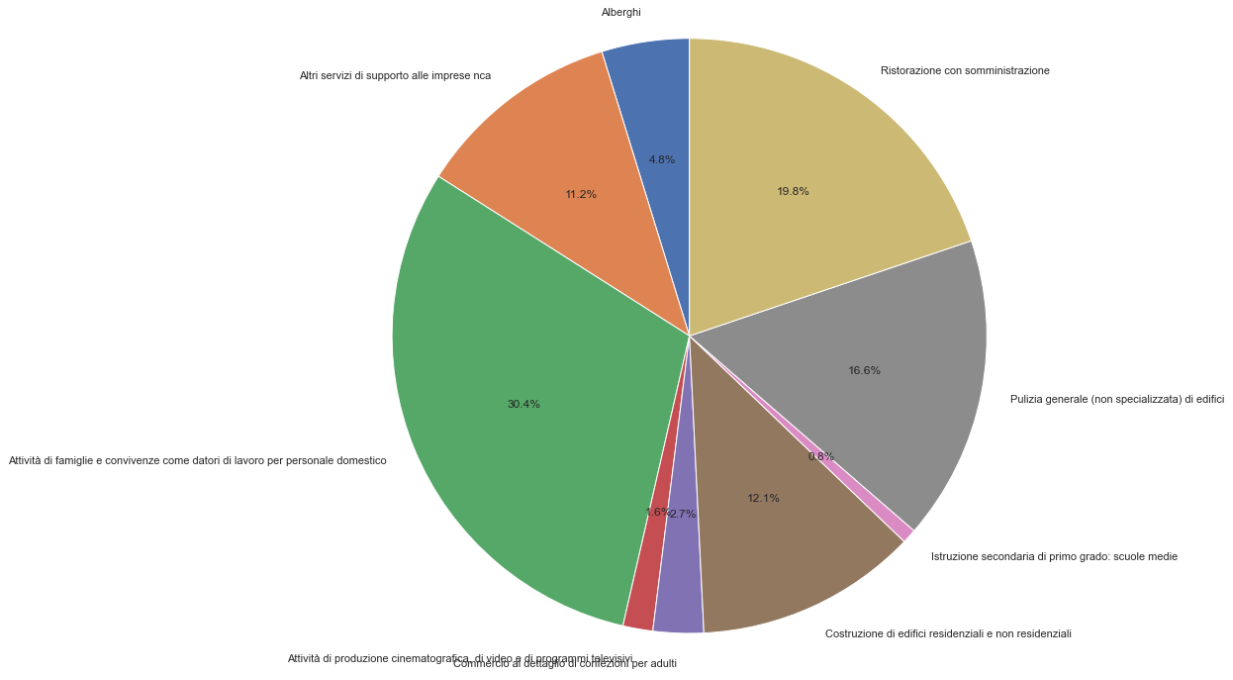

# Sondrio

### Titolo di Studio
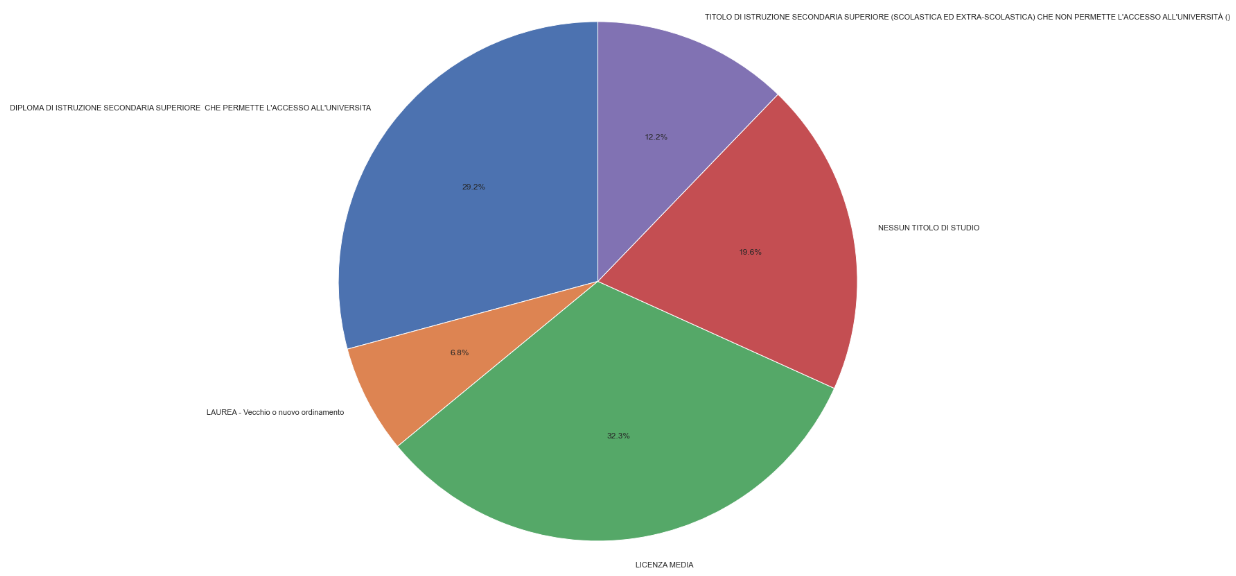

### Contratto di Lavoro
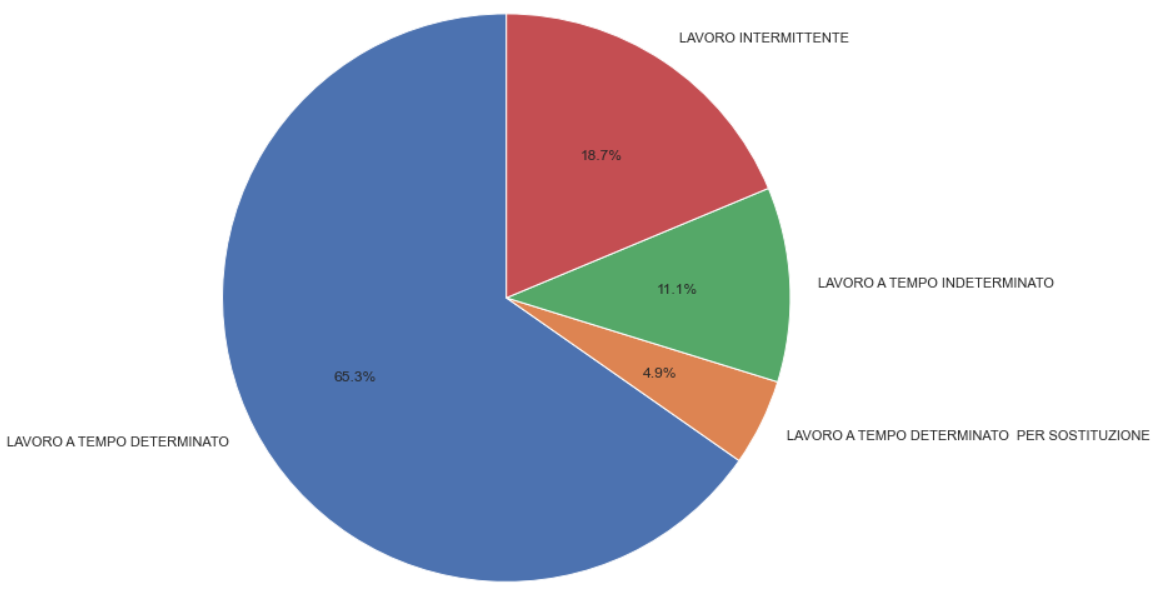

## Analisys Assumptions and Dismissals

In [33]:
Assumptions_Milano = pd.read_csv('Lavori_Attivati_Cleaning.csv')
Dismissals_Milano = pd.read_csv('Lavori_Cessati_Cleaning.csv')

In [34]:
# Change Type of DATA and SETTOREECONOMICO columns
Assumptions_Milano = Assumptions_Milano.loc[(Assumptions_Milano['PROVINCIAIMPRESA'] == 'SONDRIO')]
Assumptions_Milano['DATA'] = pd.to_datetime(Assumptions_Milano['DATA'])
Assumptions_Milano['SETTOREECONOMICO'] = pd.to_numeric(Assumptions_Milano['SETTOREECONOMICO'])

Dismissals_Milano = Dismissals_Milano.loc[(Dismissals_Milano['PROVINCIAIMPRESA'] == 'SONDRIO')]
Dismissals_Milano['DATA'] = pd.to_datetime(Dismissals_Milano['DATA'])
Dismissals_Milano['SETTOREECONOMICO'] = pd.to_numeric(Dismissals_Milano['SETTOREECONOMICO'])

In [35]:
# Time Interval is selected for Assumptions
interval_year = (Assumptions_Milano['ANNO'] > 2018) & (Assumptions_Milano['ANNO'] <= 2021)
Assumptions_Milano = Assumptions_Milano.loc[interval_year]

In [36]:
# Time Interval is selected for Dismissals
interval_year = (Dismissals_Milano['ANNO'] > 2018) & (Dismissals_Milano['ANNO'] <= 2021)
Dismissals_Milano = Dismissals_Milano.loc[interval_year]

In [37]:
# Reconstruction of the DataSet
Assumptions_Milano = Assumptions_Milano[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA', 'TIPO']]
Dismissals_Milano = Dismissals_Milano[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA', "TIPO"]]

In [38]:
Assumptions_Milano = Assumptions_Milano.groupby(["SETTOREECONOMICODETTAGLIO","SETTOREECONOMICO"]).count()
Assumptions_Milano

DATA  \
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO         
Alberghi                                           0                 4876   
Altri servizi di supporto alle imprese nca         3                  117   
Attività di famiglie e convivenze come datori d... 4                 1075   
Attività di produzione cinematografica, di vide... 1                    4   
Commercio al dettaglio di confezioni per adulti    6                  212   
Costruzione di edifici residenziali e non resid... 7                 1364   
Istruzione secondaria di primo grado: scuole medie 8                 1625   
Pulizia generale (non specializzata) di edifici    5                  496   
Ristorazione con somministrazione                  2                 3245   

                                                                     PROVINCIAIMPRESA  \
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO                     
Alberghi                                           0                             4876   
Altri servizi di supporto alle imprese nca         3                              117   
Attività di famiglie e convivenze come datori d... 4                             1075   
Attività di produzione cinematografica, di vide... 1                                4   
Commercio al dettaglio di confezioni per adulti    6                              212   
Costruzione di edifici residenziali e non resid... 7                             1364   
Istruzione secondaria di primo grado: scuole medie 8                             1625   
Pulizia generale (non specializzata) di edifici    5                              496   
Ristorazione con somministrazione                  2                             3245   

                                                                     TIPO  
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO        
Alberghi                                           0                 4876  
Altri servizi di supporto alle imprese nca         3                  117  
Attività di famiglie e convivenze come datori d... 4                 1075  
Attività di produzione cinematografica, di vide... 1                    4  
Commercio al dettaglio di confezioni per adulti    6                  212  
Costruzione di edifici residenziali e non resid... 7                 1364  
Istruzione secondaria di primo grado: scuole medie 8                 1625  
Pulizia generale (non specializzata) di edifici    5                  496  
Ristorazione con somministrazione                  2                 3245

In [39]:
Dismissals_Milano = Dismissals_Milano.groupby(["SETTOREECONOMICODETTAGLIO","SETTOREECONOMICO"]).count()
Dismissals_Milano

DATA  \
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO         
Alberghi                                           0                 1844   
Altri servizi di supporto alle imprese nca         3                  131   
Attività di famiglie e convivenze come datori d... 4                  812   
Commercio al dettaglio di confezioni per adulti    6                  101   
Costruzione di edifici residenziali e non resid... 7                  632   
Istruzione secondaria di primo grado: scuole medie 8                   57   
Pulizia generale (non specializzata) di edifici    5                  291   
Ristorazione con somministrazione                  2                 1398   

                                                                     PROVINCIAIMPRESA  \
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO                     
Alberghi                                           0                             1844   
Altri servizi di supporto alle imprese nca         3                              131   
Attività di famiglie e convivenze come datori d... 4                              812   
Commercio al dettaglio di confezioni per adulti    6                              101   
Costruzione di edifici residenziali e non resid... 7                              632   
Istruzione secondaria di primo grado: scuole medie 8                               57   
Pulizia generale (non specializzata) di edifici    5                              291   
Ristorazione con somministrazione                  2                             1398   

                                                                     TIPO  
SETTOREECONOMICODETTAGLIO                          SETTOREECONOMICO        
Alberghi                                           0                 1844  
Altri servizi di supporto alle imprese nca         3                  131  
Attività di famiglie e convivenze come datori d... 4                  812  
Commercio al dettaglio di confezioni per adulti    6                  101  
Costruzione di edifici residenziali e non resid... 7                  632  
Istruzione secondaria di primo grado: scuole medie 8                   57  
Pulizia generale (non specializzata) di edifici    5                  291  
Ristorazione con somministrazione                  2                 1398

In [40]:
# Join implementation to obtain the Counter values of hired and fired people
Combination = Assumptions_Milano.merge(Dismissals_Milano, on = "SETTOREECONOMICODETTAGLIO", how = "inner")
Combination["ATTIVATO"]= Combination["TIPO_x"]
Combination = Combination.drop(["DATA_x","TIPO_x","PROVINCIAIMPRESA_x"], axis = 1)
Combination["CESSATO"]= Combination["TIPO_y"]
Combination = Combination.drop(["DATA_y","TIPO_y","PROVINCIAIMPRESA_y"], axis = 1)
Combination

ATTIVATO  CESSATO
SETTOREECONOMICODETTAGLIO                                            
Alberghi                                                4876     1844
Altri servizi di supporto alle imprese nca               117      131
Attività di famiglie e convivenze come datori d...      1075      812
Commercio al dettaglio di confezioni per adulti          212      101
Costruzione di edifici residenziali e non resid...      1364      632
Istruzione secondaria di primo grado: scuole medie      1625       57
Pulizia generale (non specializzata) di edifici          496      291
Ristorazione con somministrazione                       3245     1398

### Assumptions Plot

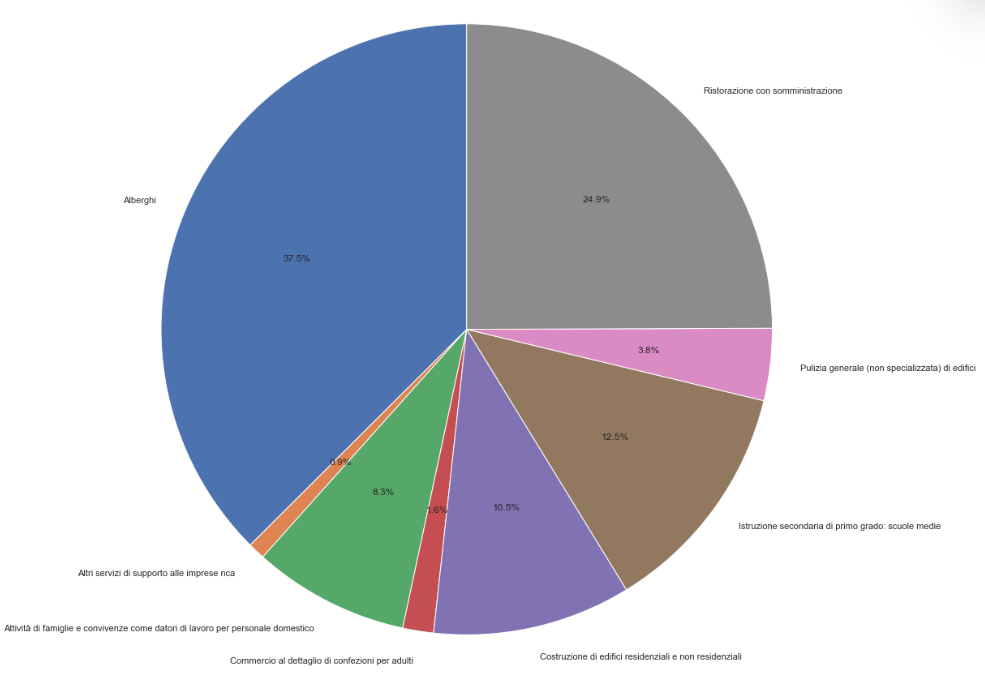

### Dismissals Plot

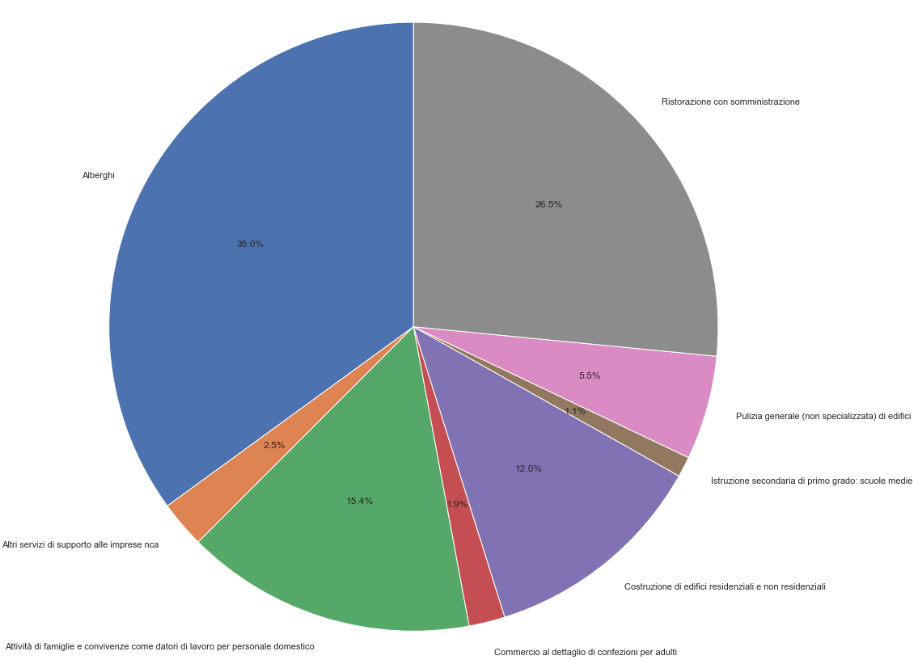

# Time Series Forecasting

Time series data is a sequence of data points indexed in time order and collected at different points in time. These data points typically consist of successive measurements made from the same source over a time interval and are used to track change over time. In the second part of the project we studied the predictions made by a statistical model and a Machine Learning model

## SARIMAX Model Implementations
SARIMAX is an autoregressive statistical model, which can predict future data using past ones. In order to implement the Sarimax prediction model, we have to find out the optimal model. For this reason, we have used Auto_Arima to discover the best configuration.

## LSTM Forecasting
LSTM Forecasting allows to predict the future values of a Time Serie adopting a Machine Learning approach.
Before starting we have scaled Training and Testing data, where the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

# Time Series Analysis

Time series analysis is a specific way of analyzing a sequence of data points collected over an interval of time, where data points are recorded at consistent intervals over a set period of time rather than just recording the data points intermittently or randomly. One of the primary purposes of the time series analysis consists in understanding the seasonal trends and stationarity and how they change over time. 

## Seasonality
Seasonality is a characteristic of a time series in which the data experiences regular and predictable changes that recur every calendar year. Any predictable fluctuation or pattern that recurs or repeats over a one-year period is said to be seasonal. 

## Hired

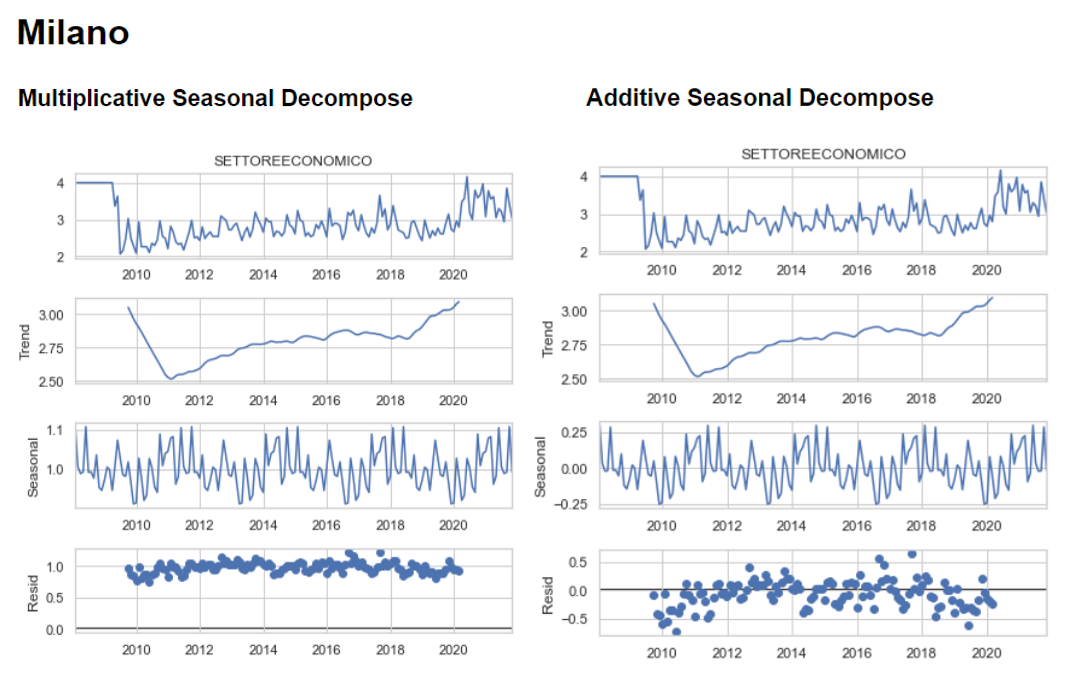

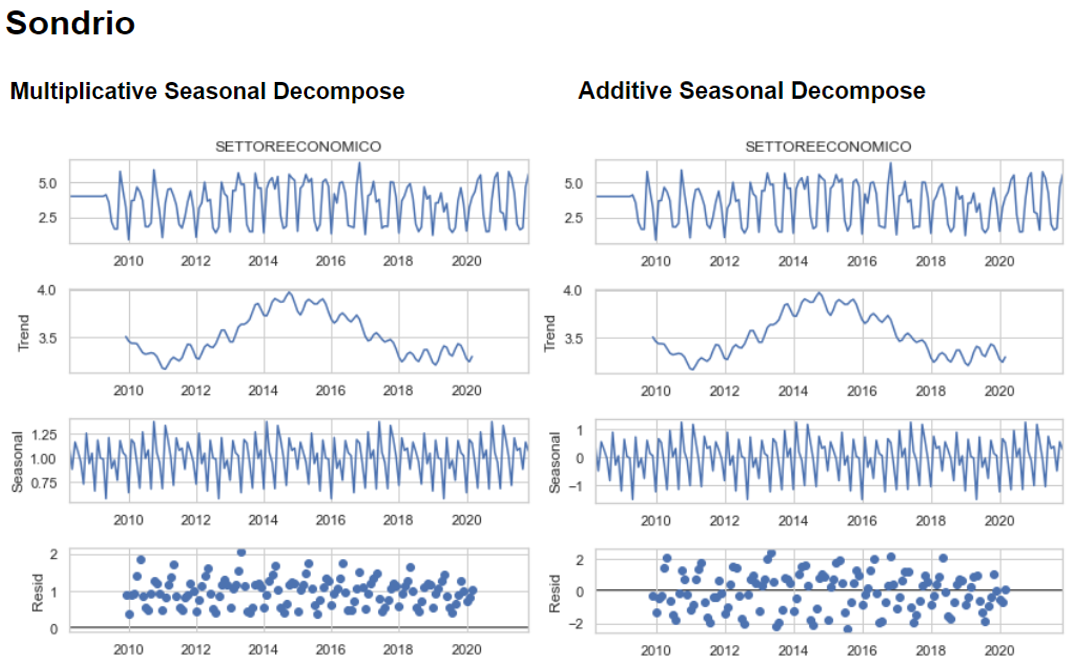

## Fired

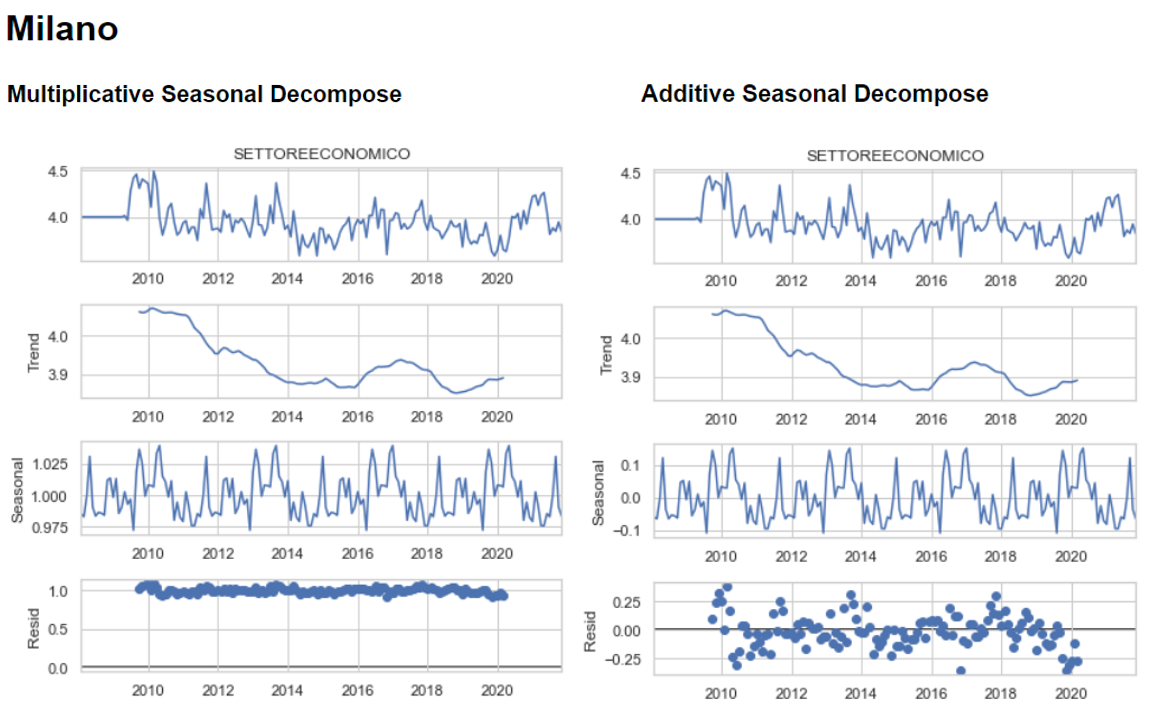

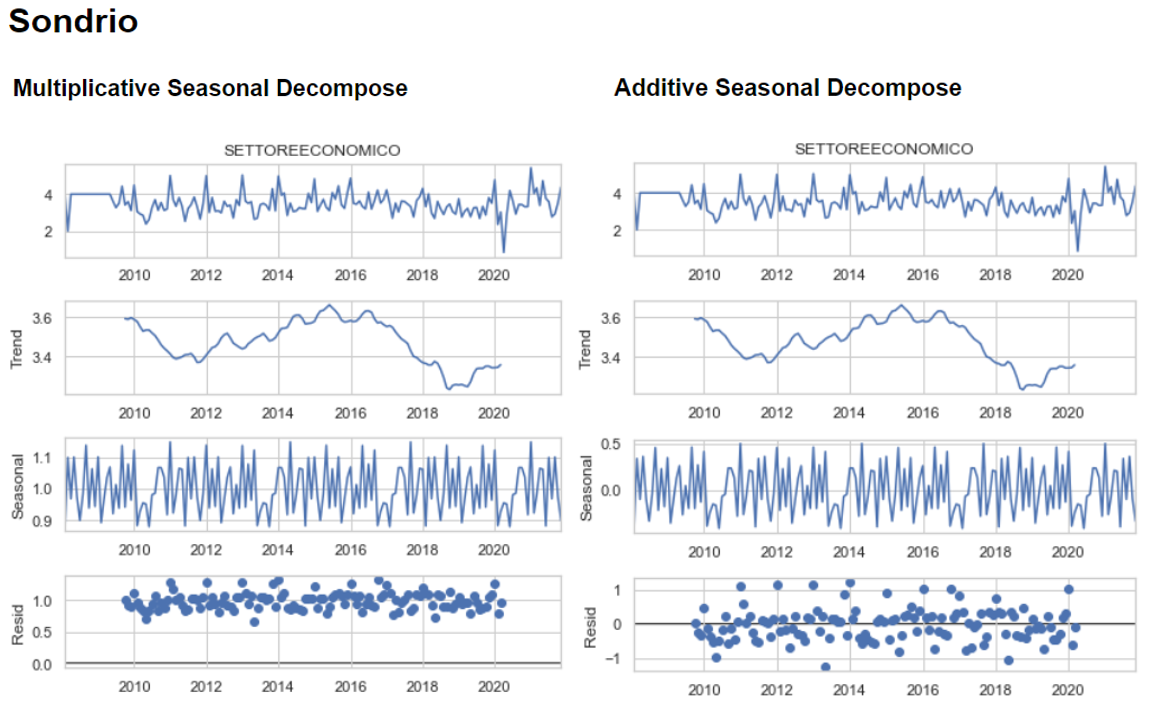

## Stationarity
A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

## Differencing
Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

## Hired Differencing

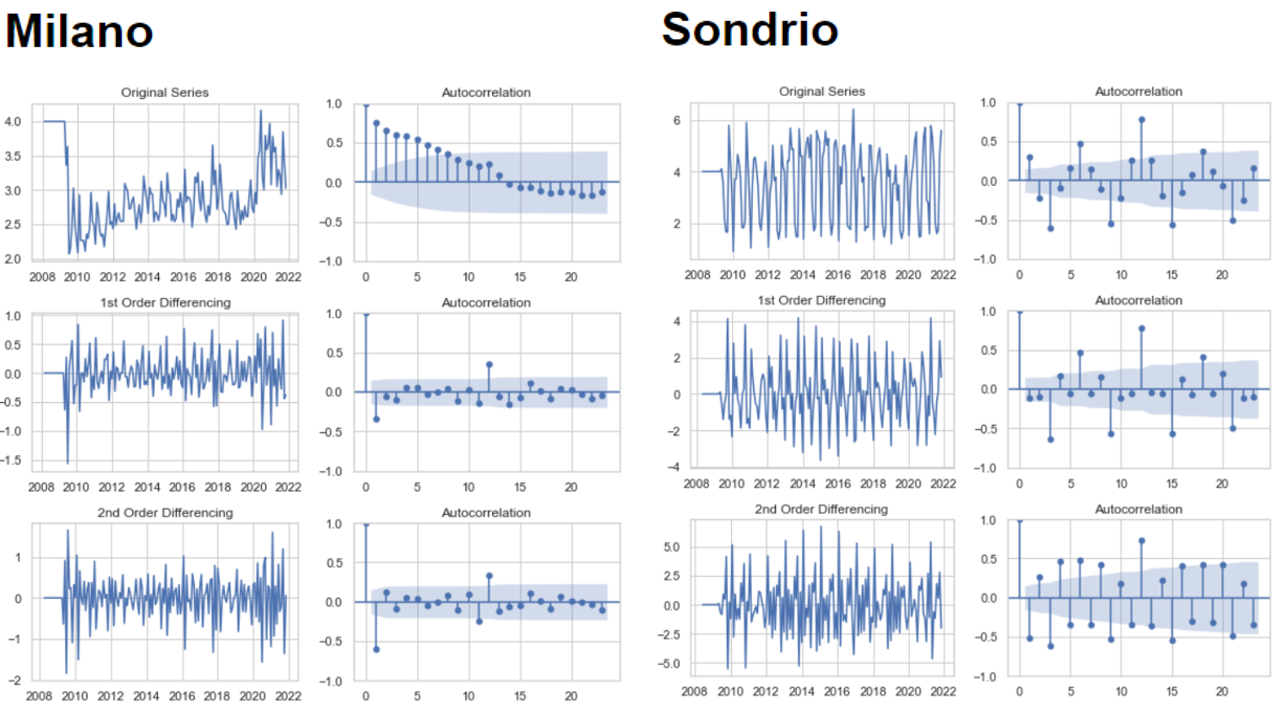

## Fired Differencing

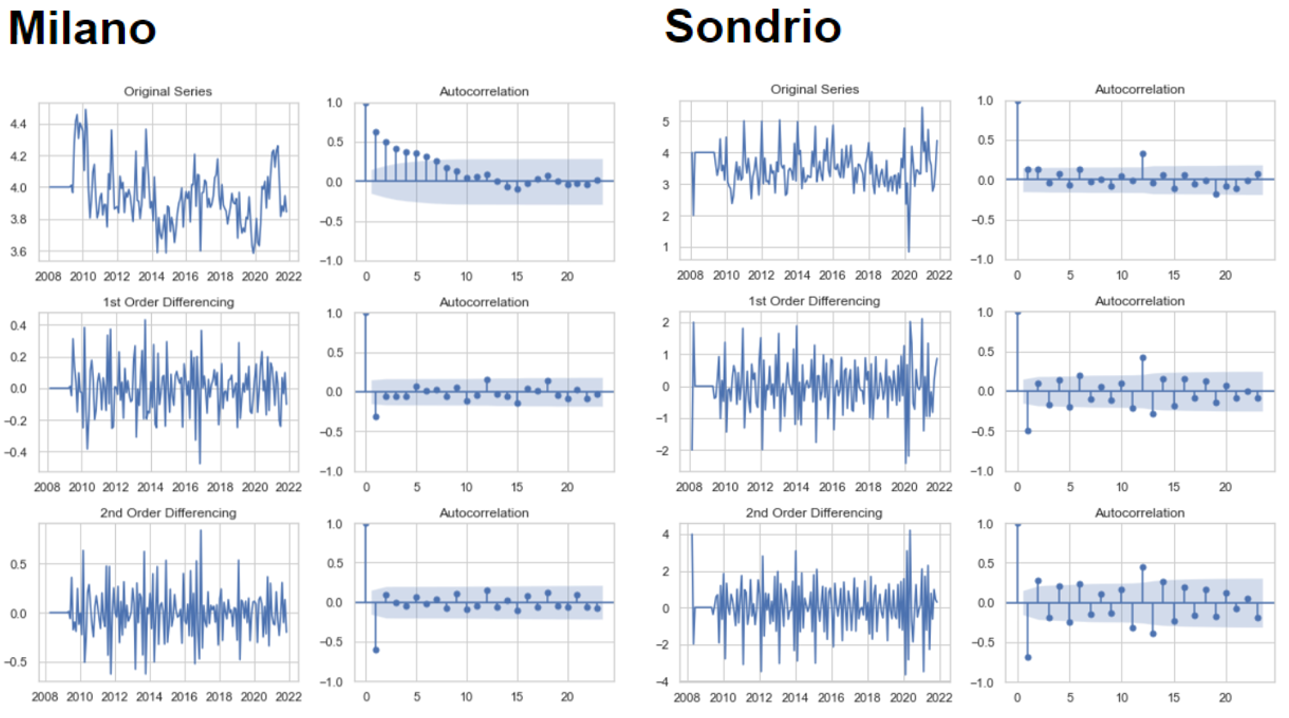

In [41]:
################################################################################################################################

# Function Definition_Milano_Hired

In [42]:
# Dynamic function to divide Dataset into testing and training set 
def Dynamic_Splitting (parDf,parColumn,parTrainSize):
    
    # Test e Train DataSet creation
    train_size = parTrainSize
    split_idx = round(len(Assumptions_Milano["SETTOREECONOMICO"])* train_size)

    # Split
    train = Assumptions_Milano.iloc[:split_idx]
    test = Assumptions_Milano.iloc[split_idx:]
    

    # Visualize split
    fig,ax= plt.subplots(figsize=(10,10))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train, test

In [43]:
################################################################################################################################

# TimeSeries_Hired_Milano

# Creation of the New DataSet for Time Serie

In [44]:
Assumptions = pd.read_csv('Lavori_Attivati_Cleaning.csv')

In [45]:
Assumptions_Milano = Assumptions.copy()

## Changing Columns Type

In [46]:
Assumptions_Milano['DATA'] = pd.to_datetime(Assumptions_Milano['DATA'])
Assumptions_Milano['SETTOREECONOMICO'] = pd.to_numeric(Assumptions_Milano['SETTOREECONOMICO'])

In [47]:
Assumptions_Milano.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
TIPO                                 object
NAZIONE                              object
ANNO                                  int64
SETTOREECONOMICO                      int64
dtype: object

In [48]:
Assumptions_Milano.PROVINCIAIMPRESA.unique()

array(['MILANO', 'SONDRIO'], dtype=object)

## Rebuilding of the DataSet

In [49]:
Assumptions_Milano = Assumptions_Milano[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA']]
Assumptions_Milano.head()

DATA                          SETTOREECONOMICODETTAGLIO  \
0 2020-09-01  Attività di famiglie e convivenze come datori ...   
1 2021-10-06  Costruzione di edifici residenziali e non resi...   
2 2021-06-11  Istruzione secondaria di primo grado: scuole m...   
3 2020-03-04  Istruzione secondaria di primo grado: scuole m...   
4 2020-11-04  Istruzione secondaria di primo grado: scuole m...   

   SETTOREECONOMICO PROVINCIAIMPRESA  
0                 4           MILANO  
1                 7           MILANO  
2                 8           MILANO  
3                 8           MILANO  
4                 8           MILANO

In [50]:
Assumptions_Milano = Assumptions_Milano[Assumptions_Milano['PROVINCIAIMPRESA'] == 'MILANO']

In [51]:
Assumptions_Milano = Assumptions_Milano.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [52]:
Assumptions_Milano.head()

SETTOREECONOMICO
DATA                        
2008-01-31               4.0
2008-02-29               4.0
2008-03-31               4.0
2008-04-30               4.0
2008-05-31               4.0

# TimeSeries Hired Milano

<AxesSubplot:xlabel='DATA'>

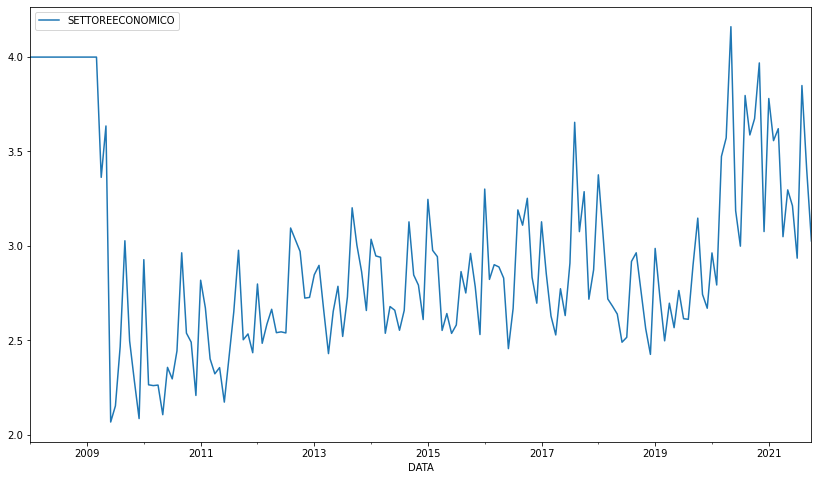

In [53]:
Assumptions_Milano.plot(figsize=(14,8))

## Seasonality

### Multiplicative Seasonal Decompose

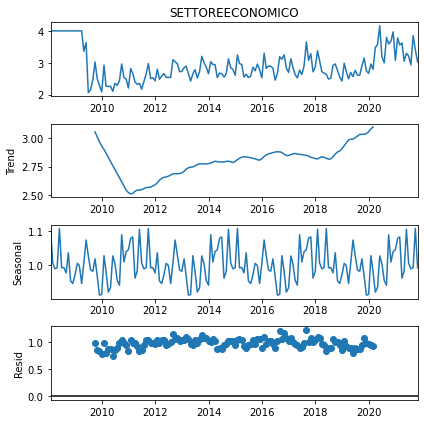

In [54]:
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul = seasonal_decompose(Assumptions_Milano['SETTOREECONOMICO'], model = 'multiplicative', period = 40)
decomposition_result = result_mul.plot()

### Additive Seasonal Decompose

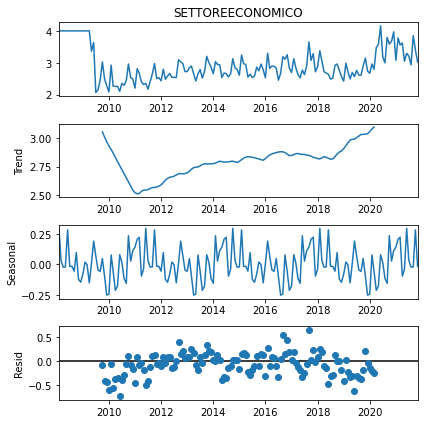

In [55]:
plt.rcParams.update({'figure.figsize': (6,6)})
result_add = seasonal_decompose(Assumptions_Milano['SETTOREECONOMICO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

In [56]:
# ADF calculation
p_value(Assumptions_Milano["SETTOREECONOMICO"])

ADF Statistic: -4.496682
p-value: 0.000199


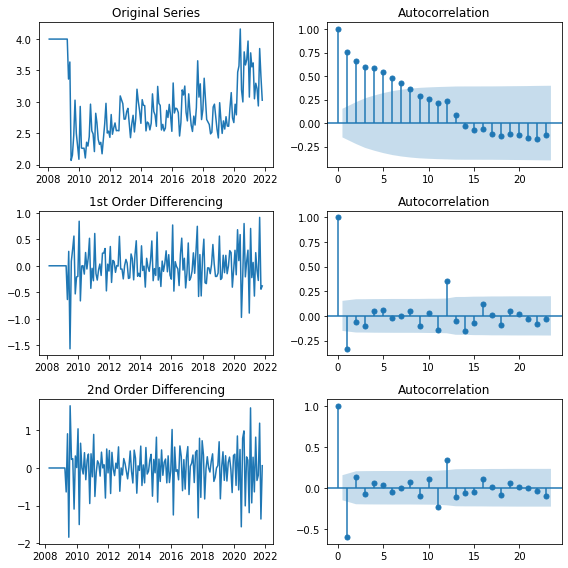

In [57]:
# Differencing plots representation
Differencing_Plot(Assumptions_Milano["SETTOREECONOMICO"])

In [58]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Assumptions_Milano["SETTOREECONOMICO"].diff())

ADF Statistic: -2.886088
p-value: 0.046990


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

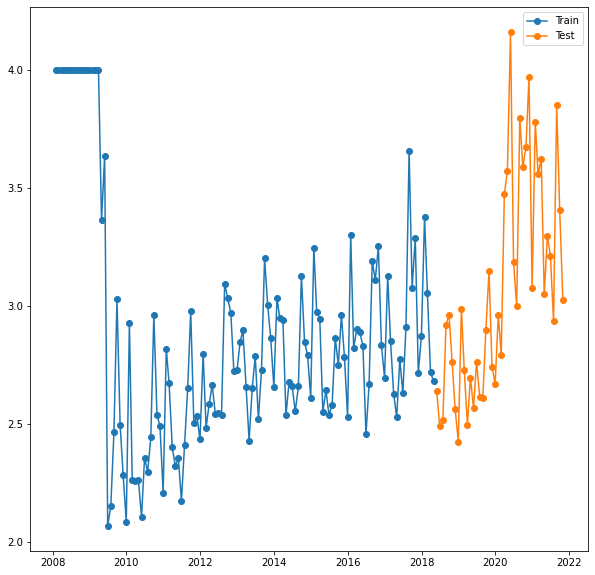

In [59]:
train, test = Dynamic_Splitting(Assumptions_Milano,"SETTOREECONOMICO",0.75)

## SARIMAX Model Implementation

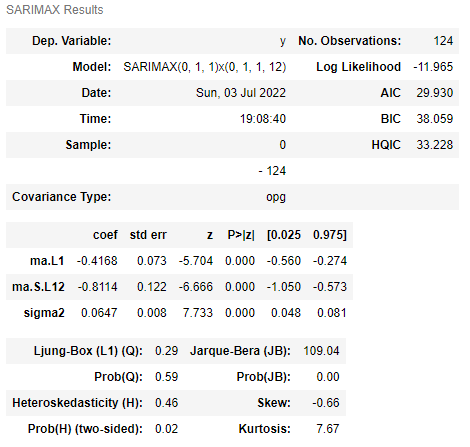

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [60]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=47.932, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=86.914, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=41.975, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=29.930, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=72.049, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=31.837, Time=0.28 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=31.841, Time=0.38 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=40.513, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=33.504, Time=1.48 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=31.262, Time=0.28 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=31.327, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=30.357, Time=0.22 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=32.882, Time=0.62 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=31.079, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  124
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -11.965
Date:                            Wed, 06 Jul 2022   AIC                             29.930
Time:                                    10:34:37   BIC                             38.059
Sample:                                         0   HQIC                            33.228
                                            - 124                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4168      0.073     -5.703      0.000      -0.560      -0.274
ma.S.L12      -0.8114      0.122     -6.665      0.000      -1.050      -0.573
sigma2         0.0647      0.008      7.732      0.000       0.048       0.081
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               109.05
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.66
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


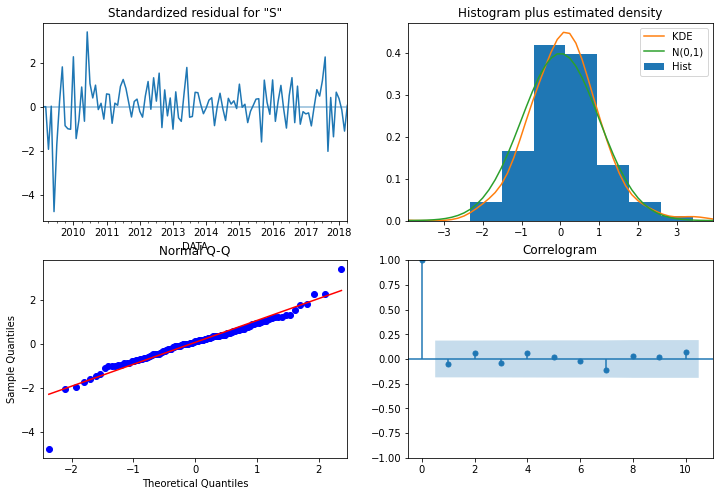

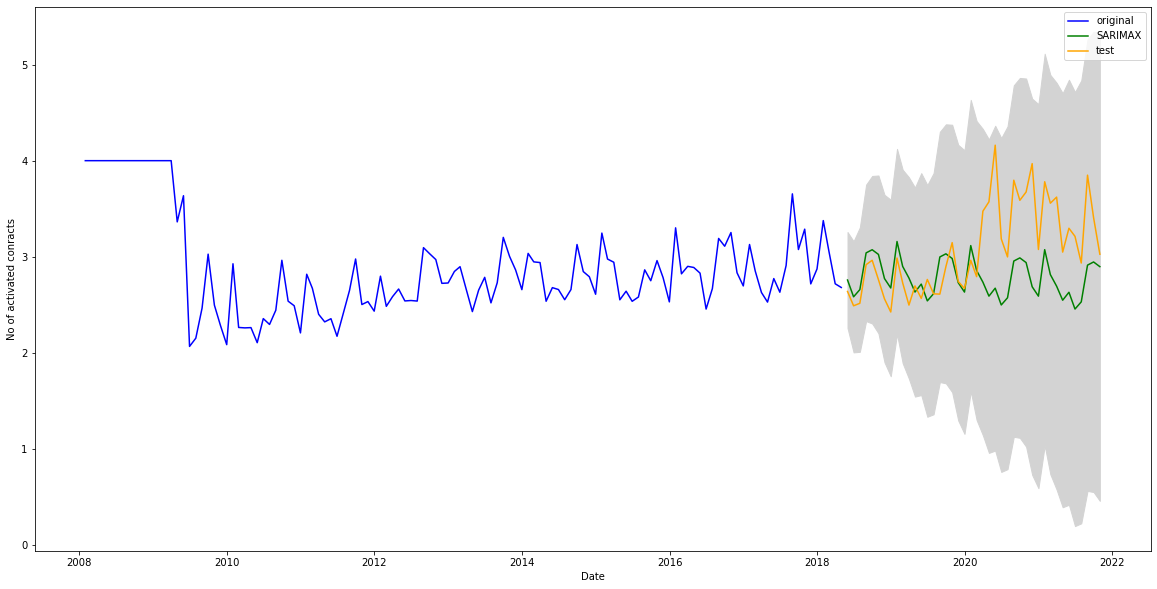

In [61]:
# Numeric values represent:
# First: Number of Test Data 
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"SETTOREECONOMICO",42,0,1,1,0,1,1,12)

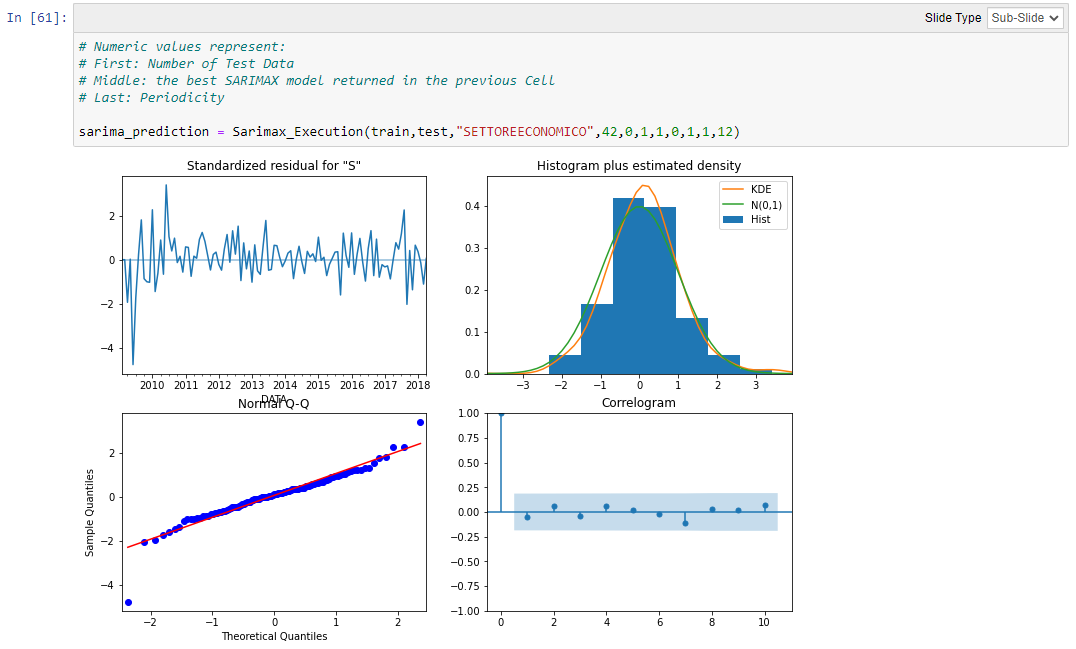

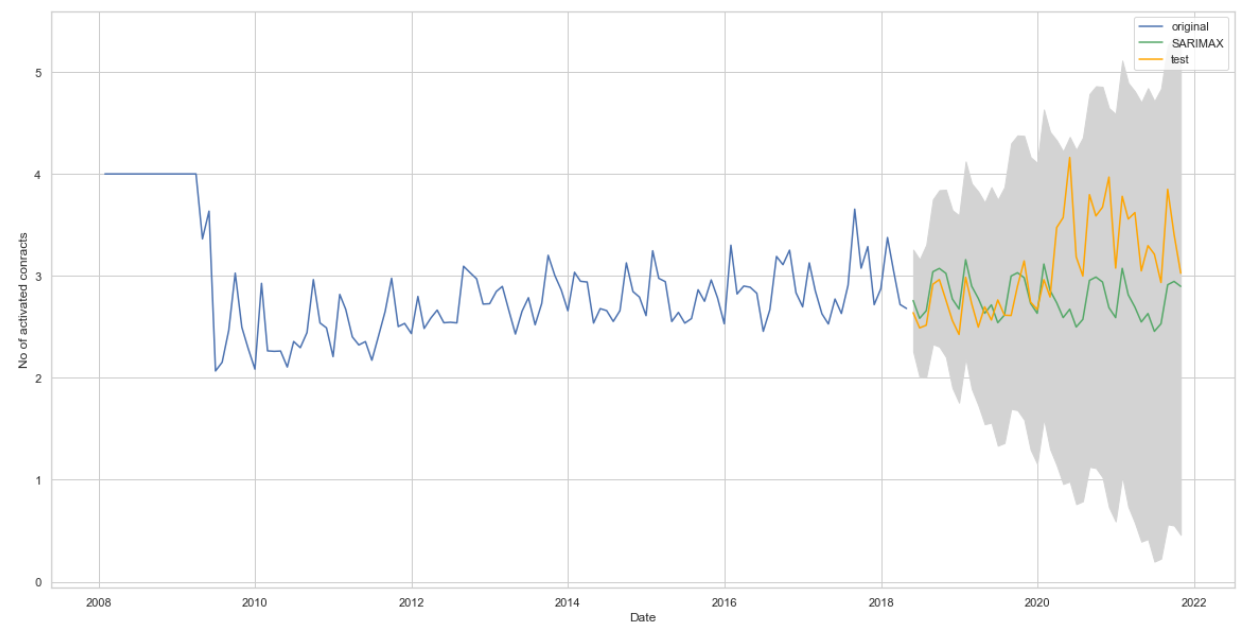

In [62]:
# Metrics of Sarima Evaluation
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 0.556152


## LSTM Forecasting

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [64]:
Assumptions_Milano.head(), Assumptions_Milano.tail()

(            SETTOREECONOMICO
 DATA                        
 2008-01-31               4.0
 2008-02-29               4.0
 2008-03-31               4.0
 2008-04-30               4.0
 2008-05-31               4.0,
             SETTOREECONOMICO
 DATA                        
 2021-06-30          3.212343
 2021-07-31          2.934975
 2021-08-31          3.849288
 2021-09-30          3.406922
 2021-10-31          3.026198)

In [65]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [66]:
scaled_train[:15]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

Elements contained in the 2 datasets are related in proportion to their value.

In [67]:
# Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [68]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Prediction: 
[[1.]]


In [69]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [70]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.fit(generator, epochs = 300)  #Epochs = Number of Iterations

Epoch 1/300
112/112 [==============================] - 2s 4ms/step - loss: 0.0419
Epoch 2/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0289
Epoch 3/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0307
Epoch 4/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0272
Epoch 5/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0286
Epoch 6/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 7/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0277
Epoch 8/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0276
Epoch 9/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 10/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 11/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 12/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0262
Epoch 13/300


112/112 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 197/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 198/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 199/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 200/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0080
Epoch 201/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 202/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 203/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 204/300
112/112 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 205/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 206/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 207/300
112/112 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 

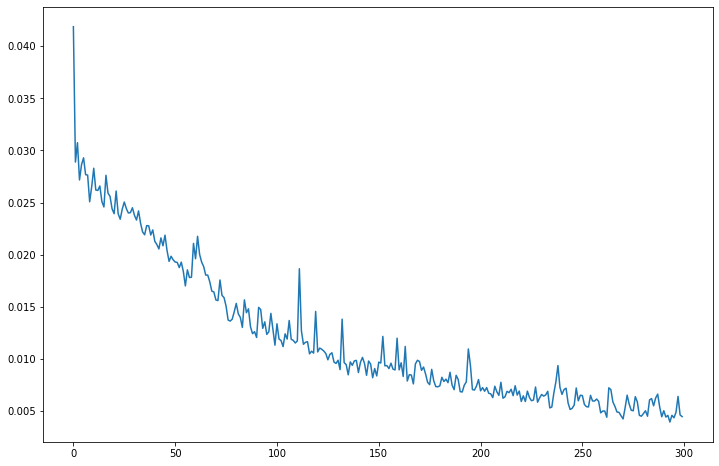

In [73]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [74]:
last_train_batch = scaled_train[-12:]

In [75]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [76]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 175ms/step


array([[0.33722883]], dtype=float32)

In [77]:
scaled_test[0]

array([0.29585935])

In [78]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 17ms/step


In [79]:
test_predictions

[array([0.33722883], dtype=float32),
 array([0.29592597], dtype=float32),
 array([0.5048272], dtype=float32),
 array([0.66624844], dtype=float32),
 array([0.41141447], dtype=float32),
 array([0.45194846], dtype=float32),
 array([0.30500475], dtype=float32),
 array([0.5011625], dtype=float32),
 array([0.6809659], dtype=float32),
 array([0.52196634], dtype=float32),
 array([0.29566813], dtype=float32),
 array([0.2609732], dtype=float32),
 array([0.30245388], dtype=float32),
 array([0.32686138], dtype=float32),
 array([0.44784826], dtype=float32),
 array([0.6507809], dtype=float32),
 array([0.2686051], dtype=float32),
 array([0.31664816], dtype=float32),
 array([0.27138323], dtype=float32),
 array([0.5441871], dtype=float32),
 array([0.7071893], dtype=float32),
 array([0.31926423], dtype=float32),
 array([0.24551274], dtype=float32),
 array([0.23134649], dtype=float32),
 array([0.27371258], dtype=float32),
 array([0.38403317], dtype=float32),
 array([0.3642843], dtype=float32),
 array([0.

In [80]:
test.head()

SETTOREECONOMICO
DATA                        
2018-05-31          2.638898
2018-06-30          2.489824
2018-07-31          2.515770
2018-08-31          2.917741
2018-09-30          2.963417

In [81]:
true_predictions = scaler.inverse_transform(test_predictions)

In [82]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_15400/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [83]:
test.head()

SETTOREECONOMICO  Predictions
DATA                                     
2018-05-31          2.638898     2.718865
2018-06-30          2.489824     2.639027
2018-07-31          2.515770     3.042832
2018-08-31          2.917741     3.354859
2018-09-30          2.963417     2.862266

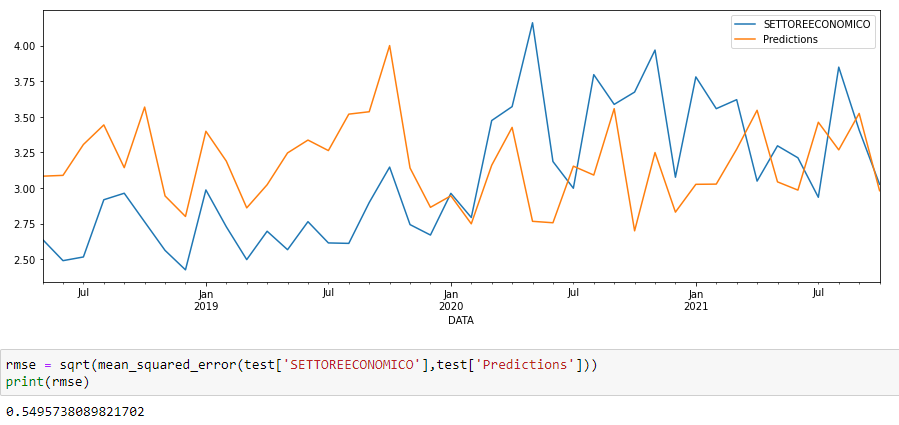

<AxesSubplot:xlabel='DATA'>

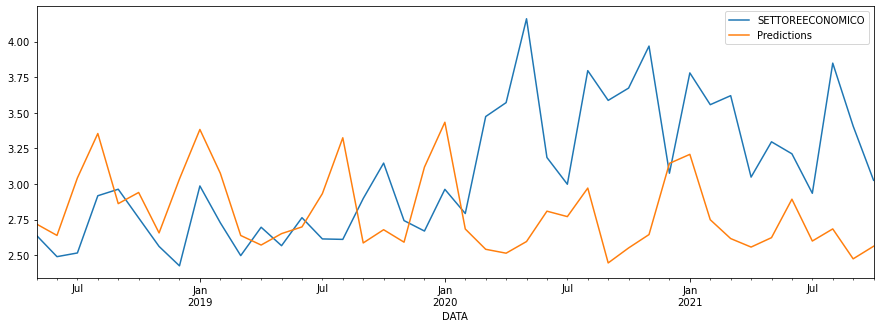

In [84]:
test.plot(figsize = (15,5))

In [85]:
rmse = sqrt(mean_squared_error(test['SETTOREECONOMICO'],test['Predictions']))
print(rmse)

0.6474263487028047


In [86]:
################################################################################################################################

# Function Definition_Sondrio_Hired

In [87]:
# Dynamic function to divide Dataset into testing and training set 
def Dynamic_Splitting (parDf,parColumn,parTrainSize):
    
    # Test e Train DataSet creation
    train_size = parTrainSize
    split_idx = round(len(Assumptions_Sondrio["SETTOREECONOMICO"])* train_size)

    # Split
    train = Assumptions_Sondrio.iloc[:split_idx]
    test = Assumptions_Sondrio.iloc[split_idx:]
    

    # Visualize split
    fig,ax= plt.subplots(figsize=(10,10))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train, test

In [88]:
################################################################################################################################

# TimeSeries_Hired_Sondrio

# Creation of the New DataSet for Time Series

In [89]:
Assumptions = pd.read_csv('Lavori_Attivati_Cleaning.csv')

In [90]:
Assumptions_Sondrio = Assumptions.copy()

## Changing Columns Type

In [91]:
Assumptions_Sondrio['DATA'] = pd.to_datetime(Assumptions_Sondrio['DATA'])
Assumptions_Sondrio['SETTOREECONOMICO'] = pd.to_numeric(Assumptions_Sondrio['SETTOREECONOMICO'])

In [92]:
Assumptions_Sondrio.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
TIPO                                 object
NAZIONE                              object
ANNO                                  int64
SETTOREECONOMICO                      int64
dtype: object

In [93]:
Assumptions_Sondrio.PROVINCIAIMPRESA.unique()

array(['MILANO', 'SONDRIO'], dtype=object)

## Rebuilding of the DataSet

In [94]:
Assumptions_Sondrio = Assumptions_Sondrio[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA']]
Assumptions_Sondrio.head()

DATA                          SETTOREECONOMICODETTAGLIO  \
0 2020-09-01  Attività di famiglie e convivenze come datori ...   
1 2021-10-06  Costruzione di edifici residenziali e non resi...   
2 2021-06-11  Istruzione secondaria di primo grado: scuole m...   
3 2020-03-04  Istruzione secondaria di primo grado: scuole m...   
4 2020-11-04  Istruzione secondaria di primo grado: scuole m...   

   SETTOREECONOMICO PROVINCIAIMPRESA  
0                 4           MILANO  
1                 7           MILANO  
2                 8           MILANO  
3                 8           MILANO  
4                 8           MILANO

In [95]:
Assumptions_Sondrio = Assumptions_Sondrio[Assumptions_Sondrio['PROVINCIAIMPRESA'] == 'SONDRIO']

In [96]:
Assumptions_Sondrio = Assumptions_Sondrio.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [97]:
Assumptions_Sondrio['SETTOREECONOMICO'] = Assumptions_Sondrio['SETTOREECONOMICO'].ffill()

# TimeSeries Hired Sondrio

<AxesSubplot:xlabel='DATA'>

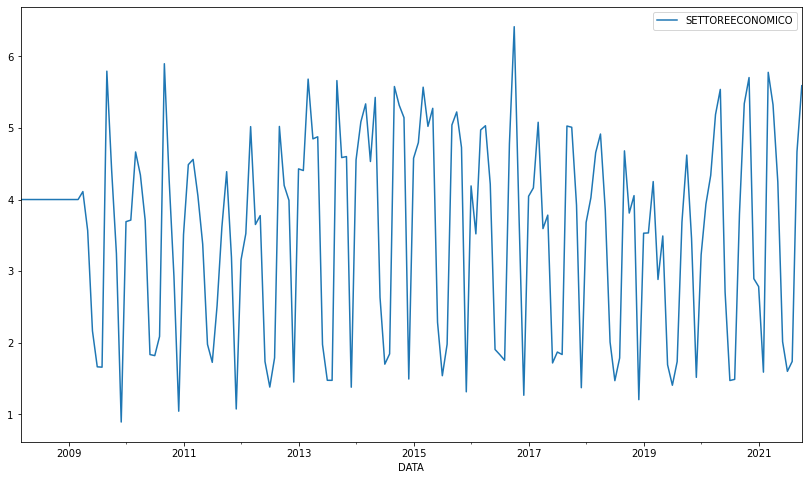

In [98]:
Assumptions_Sondrio.plot(figsize=(14,8))

## Seasonality

### Multiplicative Seasonal Decompose

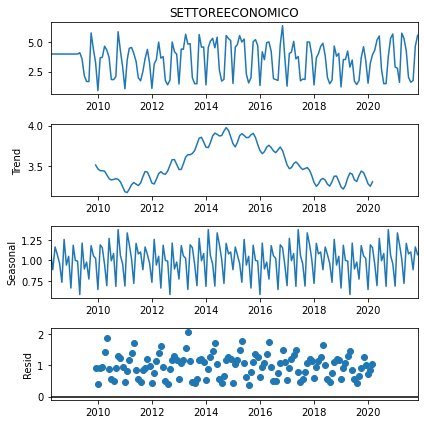

In [99]:
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul = seasonal_decompose(Assumptions_Sondrio['SETTOREECONOMICO'], model = 'multiplicative', period = 40)
decomposition_result = result_mul.plot()

### Additive Seasonal Decompose

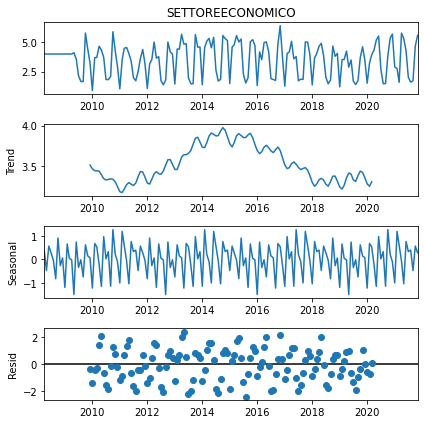

In [100]:
plt.rcParams.update({'figure.figsize': (6,6)})
result_add = seasonal_decompose(Assumptions_Sondrio['SETTOREECONOMICO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

In [101]:
# ADF calculation
p_value(Assumptions_Sondrio["SETTOREECONOMICO"])

ADF Statistic: -2.082575
p-value: 0.251579


## Stationarity

### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

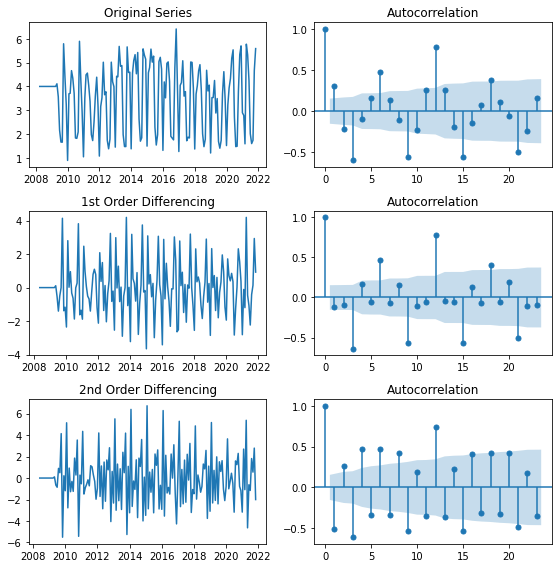

In [102]:
# Differencing plots representation
Differencing_Plot(Assumptions_Sondrio["SETTOREECONOMICO"])

In [103]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Assumptions_Sondrio["SETTOREECONOMICO"].diff())

ADF Statistic: -13.626590
p-value: 0.000000


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

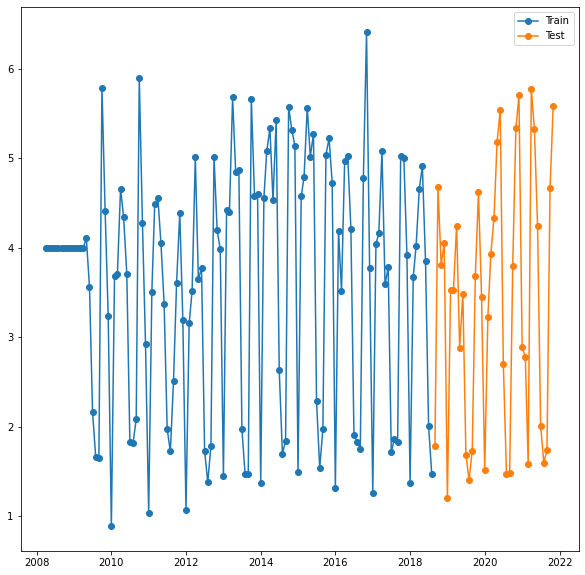

In [104]:
train, test = Dynamic_Splitting(Assumptions_Sondrio,"SETTOREECONOMICO",0.76)

## SARIMAX Model Creation

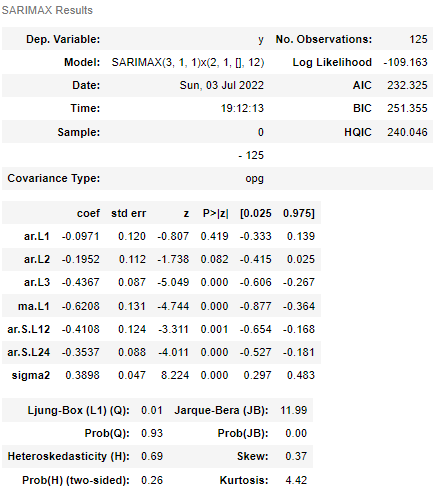

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [105]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=290.383, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=309.569, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=286.520, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=247.056, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=256.667, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=248.381, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=247.526, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=253.089, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=247.388, Time=1.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=247.153, Time=0.19 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=246.997, Time=0.17 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=257.734, Time=0.06 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=248.200, Time=0.32 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=247.239, Time=0.44 sec
 ARIMA(0,1,2)(1,1,0)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  125
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                -109.163
Date:                             Wed, 06 Jul 2022   AIC                            232.325
Time:                                     10:37:42   BIC                            251.355
Sample:                                          0   HQIC                           240.046
                                             - 125                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0971      0.120     -0.807      0.419      -0.333       0.139
ar.L2         -0.1952      0.112     -1.738      0.082      -0.415       0.025
ar.L3         -0.4367      0.087     -5.049      0.000      -0.606      -0.267
ma.L1         -0.6208      0.131     -4.744      0.000      -0.877      -0.364
ar.S.L12      -0.4108      0.124     -3.311      0.001      -0.654      -0.168
ar.S.L24      -0.3537      0.088     -4.011      0.000      -0.527      -0.181
sigma2         0.3898      0.047      8.224      0.000       0.297       0.483
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.99
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.37
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


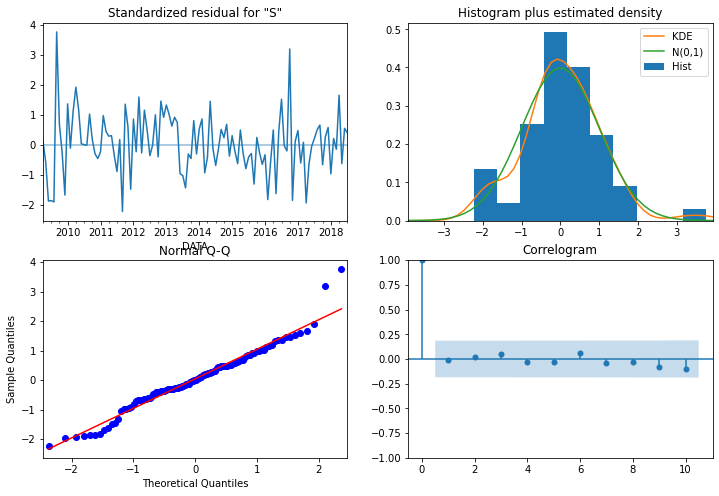

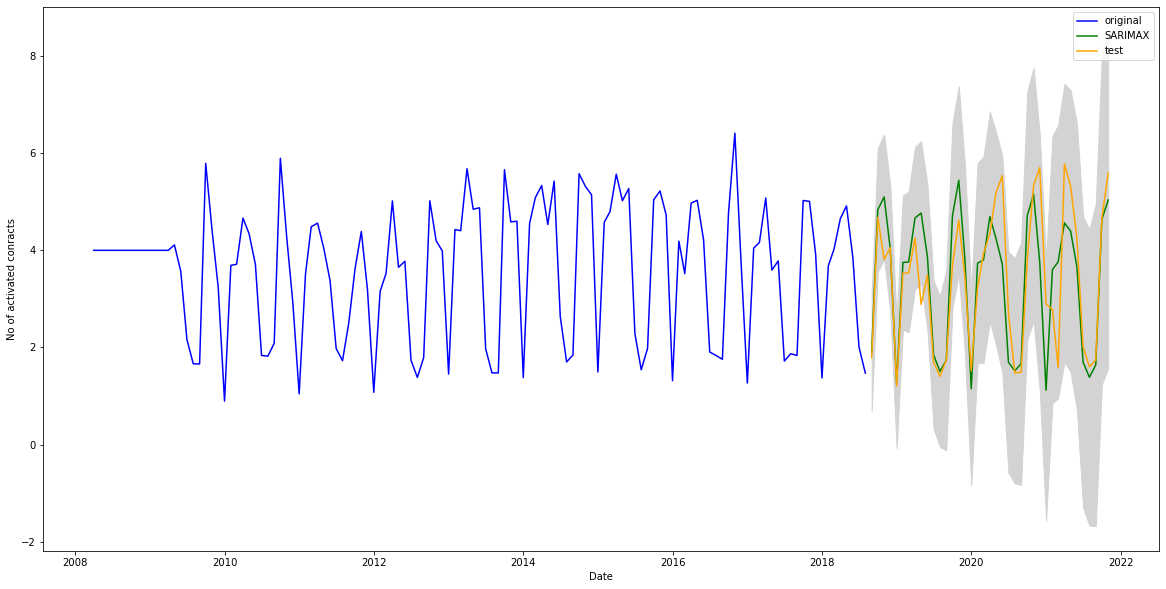

In [106]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"SETTOREECONOMICO",39,3,1,1,2,1,0,12)

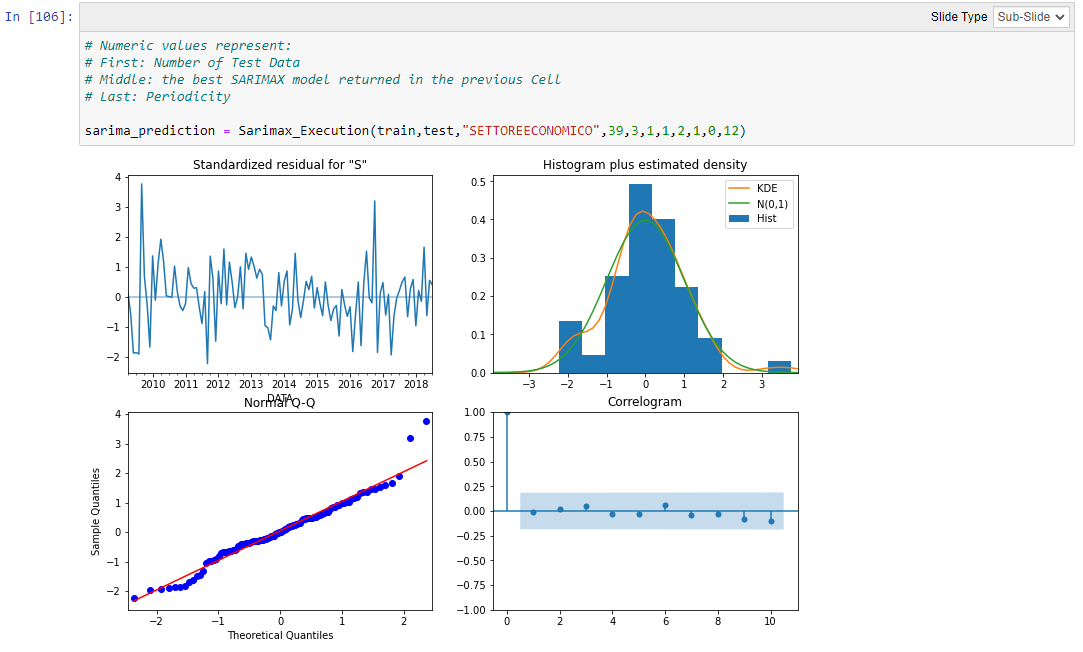

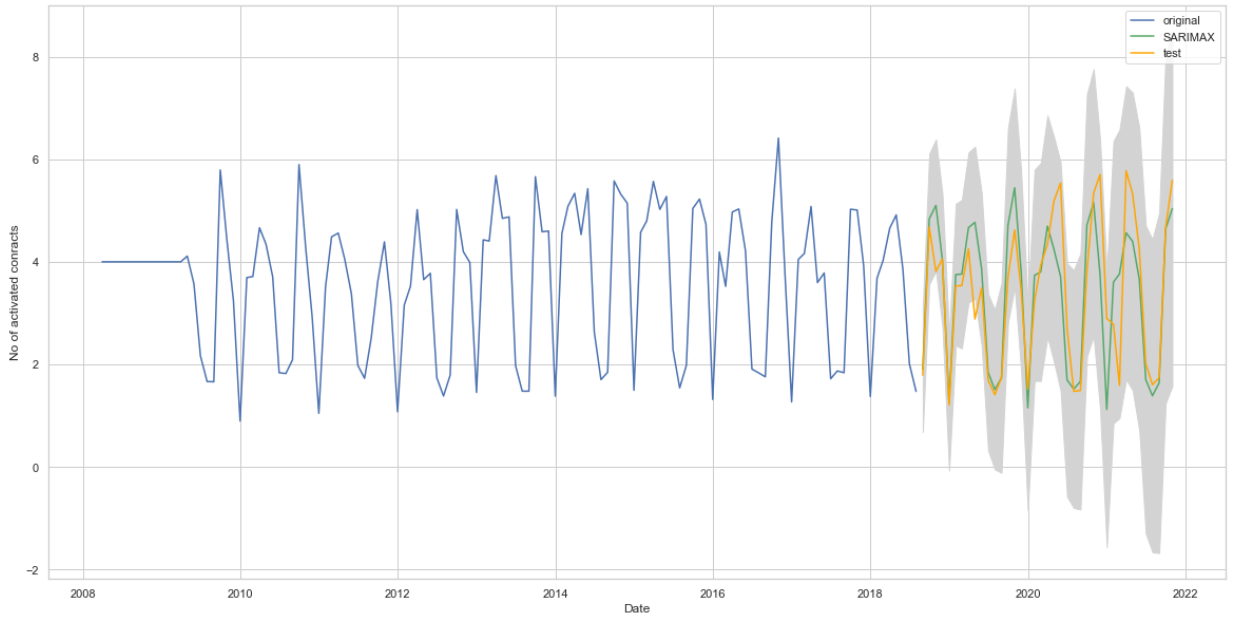

In [107]:
# Metrics of Sarima Evaluation
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 0.872873


## LSTM Forecasting

In [108]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [109]:
Assumptions_Sondrio.head(), Assumptions_Sondrio.tail()

(            SETTOREECONOMICO
 DATA                        
 2008-03-31               4.0
 2008-04-30               4.0
 2008-05-31               4.0
 2008-06-30               4.0
 2008-07-31               4.0,
             SETTOREECONOMICO
 DATA                        
 2021-06-30          2.014531
 2021-07-31          1.600619
 2021-08-31          1.738710
 2021-09-30          4.666667
 2021-10-31          5.589552)

In [110]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [111]:
scaled_train[:15]

array([[0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.5628127 ],
       [0.58293813],
       [0.48432351]])

In [112]:
#Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [113]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.5628127 0.5628127 0.5628127 0.5628127 0.5628127 0.5628127 0.5628127
 0.5628127 0.5628127 0.5628127 0.5628127 0.5628127]
Prediction: 
[[0.5628127]]


In [114]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [115]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [116]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.fit(generator, epochs = 200)  #Epochs = Number of Iterations

Epoch 1/200
113/113 [==============================] - 2s 4ms/step - loss: 0.0811
Epoch 2/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0808
Epoch 3/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0756
Epoch 4/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0698
Epoch 5/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0594
Epoch 6/200
113/113 [==============================] - 1s 5ms/step - loss: 0.0614
Epoch 7/200
113/113 [==============================] - 1s 5ms/step - loss: 0.0490
Epoch 8/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0576
Epoch 9/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0454
Epoch 10/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0466
Epoch 11/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0415
Epoch 12/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0395
Epoch 13/200


113/113 [==============================] - 0s 4ms/step - loss: 0.0079
Epoch 197/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 198/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 199/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 200/200
113/113 [==============================] - 0s 4ms/step - loss: 0.0037


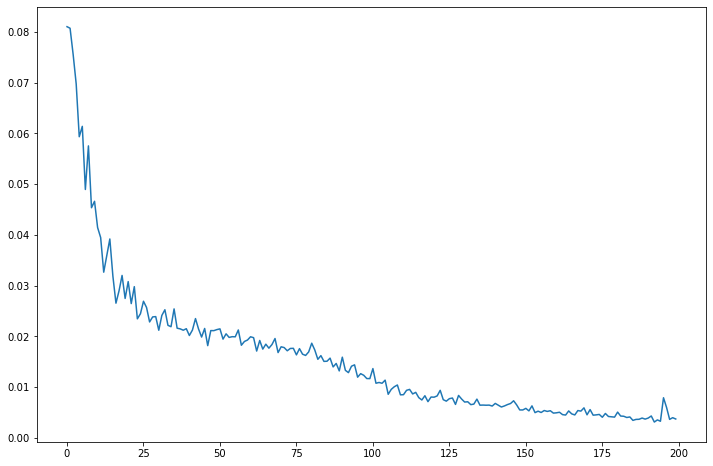

In [118]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [119]:
last_train_batch = scaled_train[-12:]

In [120]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [121]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 364ms/step


array([[0.11609408]], dtype=float32)

In [122]:
scaled_test[0]

array([0.16201687])

In [123]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 18ms/step


In [124]:
test_predictions

[array([0.11609408], dtype=float32),
 array([0.88346416], dtype=float32),
 array([0.80815464], dtype=float32),
 array([0.60862905], dtype=float32),
 array([0.08297054], dtype=float32),
 array([0.5929525], dtype=float32),
 array([0.59825337], dtype=float32),
 array([0.73501796], dtype=float32),
 array([0.656289], dtype=float32),
 array([0.64050055], dtype=float32),
 array([0.23000142], dtype=float32),
 array([0.14898622], dtype=float32),
 array([0.13657525], dtype=float32),
 array([0.7533059], dtype=float32),
 array([0.8745353], dtype=float32),
 array([0.6393835], dtype=float32),
 array([0.08150157], dtype=float32),
 array([0.60368764], dtype=float32),
 array([0.58939815], dtype=float32),
 array([0.75127006], dtype=float32),
 array([0.630224], dtype=float32),
 array([0.61556023], dtype=float32),
 array([0.21175793], dtype=float32),
 array([0.14441063], dtype=float32),
 array([0.10897298], dtype=float32),
 array([0.7286668], dtype=float32),
 array([0.9039059], dtype=float32),
 array([0.6

In [125]:
test.head()

SETTOREECONOMICO
DATA                        
2018-08-31          1.787234
2018-09-30          4.679654
2018-10-31          3.811083
2018-11-30          4.054545
2018-12-31          1.205009

In [126]:
true_predictions = scaler.inverse_transform(test_predictions)

In [127]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_15400/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [128]:
test.head()

SETTOREECONOMICO  Predictions
DATA                                     
2018-08-31          1.787234     1.533698
2018-09-30          4.679654     5.770294
2018-10-31          3.811083     5.354516
2018-11-30          4.054545     4.252949
2018-12-31          1.205009     1.350825

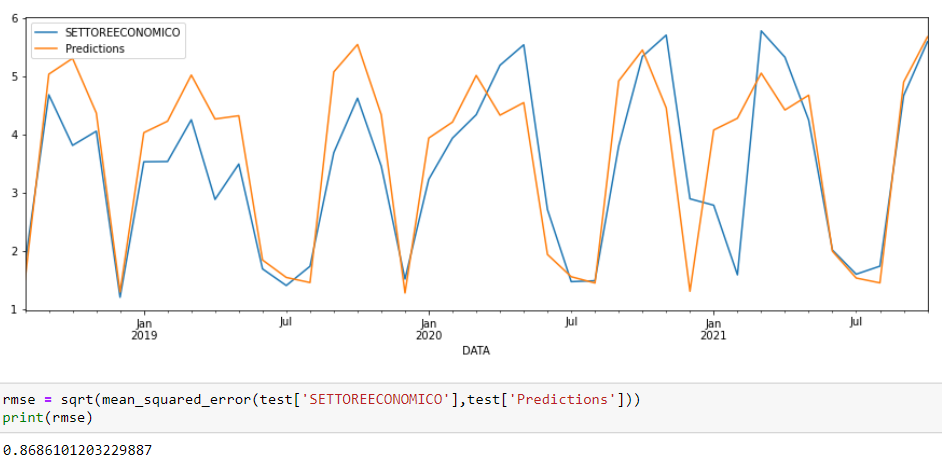

<AxesSubplot:xlabel='DATA'>

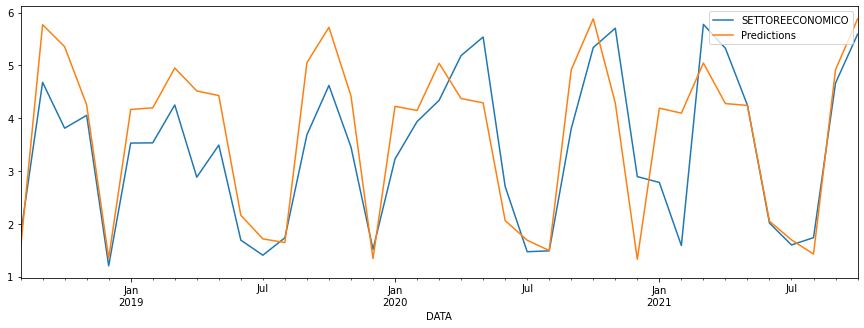

In [129]:
test.plot(figsize = (15,5))

In [130]:
rmse = sqrt(mean_squared_error(test['SETTOREECONOMICO'],test['Predictions']))
print(rmse)

0.9239517830848584


In [131]:
################################################################################################################################

# Function Definition_Milano_Fired

In [132]:
# Dynamic function to divide Dataset into testing and training set 
def Dynamic_Splitting (parDf,parColumn,parTrainSize):
    
    # Test e Train DataSet creation
    train_size = parTrainSize
    split_idx = round(len(Dismissals_Milano["SETTOREECONOMICO"])* train_size)

    # Split
    train = Dismissals_Milano.iloc[:split_idx]
    test = Dismissals_Milano.iloc[split_idx:]
    

    # Visualize split
    fig,ax= plt.subplots(figsize=(10,10))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train, test

In [133]:
################################################################################################################################

# TimeSeries_Fired_Milano

## Creation of the New DataSet for Time Serie

In [134]:
Dismissals = pd.read_csv('Lavori_Cessati_Cleaning.csv')

In [135]:
Dismissals_Milano = Dismissals.copy()

### Changing Columns Type

In [136]:
Dismissals_Milano['DATA'] = pd.to_datetime(Dismissals_Milano['DATA'])
Dismissals_Milano['SETTOREECONOMICO'] = pd.to_numeric(Dismissals_Milano['SETTOREECONOMICO'])

In [137]:
Dismissals_Milano.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
TIPO                                 object
NAZIONE                              object
ANNO                                  int64
SETTOREECONOMICO                      int64
dtype: object

In [138]:
Dismissals_Milano.PROVINCIAIMPRESA.unique()

array(['MILANO', 'SONDRIO'], dtype=object)

### Rebuilding of the DataSet

In [139]:
Dismissals_Milano = Dismissals_Milano[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA']]
Dismissals_Milano.head()

DATA                          SETTOREECONOMICODETTAGLIO  \
0 2021-03-11  Attività di famiglie e convivenze come datori ...   
1 2021-05-03  Costruzione di edifici residenziali e non resi...   
2 2021-05-12  Costruzione di edifici residenziali e non resi...   
3 2019-04-08                  Ristorazione con somministrazione   
4 2020-12-04  Attività di famiglie e convivenze come datori ...   

   SETTOREECONOMICO PROVINCIAIMPRESA  
0                 4           MILANO  
1                 7           MILANO  
2                 7           MILANO  
3                 2           MILANO  
4                 4           MILANO

In [140]:
Dismissals_Milano = Dismissals_Milano[Dismissals_Milano['PROVINCIAIMPRESA'] == 'MILANO']

In [141]:
Dismissals_Milano = Dismissals_Milano.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [142]:
Dismissals_Milano.head()

SETTOREECONOMICO
DATA                        
2008-01-31               4.0
2008-02-29               4.0
2008-03-31               4.0
2008-04-30               4.0
2008-05-31               4.0

# TimeSeries Fired Milano

<AxesSubplot:xlabel='DATA'>

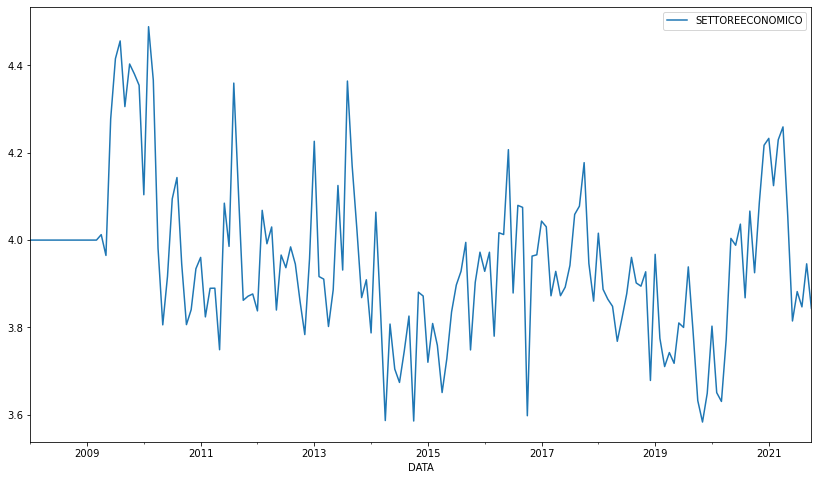

In [143]:
Dismissals_Milano.plot(figsize=(14,8))

## Seasonality

### Multiplicative Seasonal Decompose

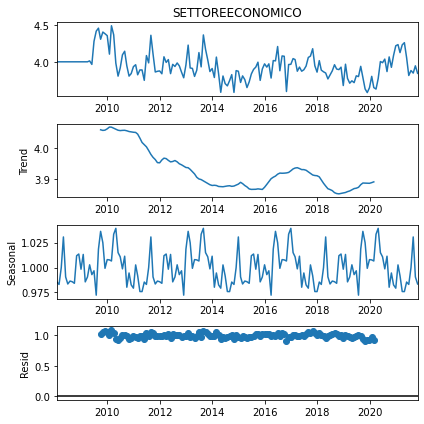

In [144]:
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul = seasonal_decompose(Dismissals_Milano['SETTOREECONOMICO'], model = 'multiplicative', period = 40)
decomposition_result = result_mul.plot()

### Additive Seasonal Decompose

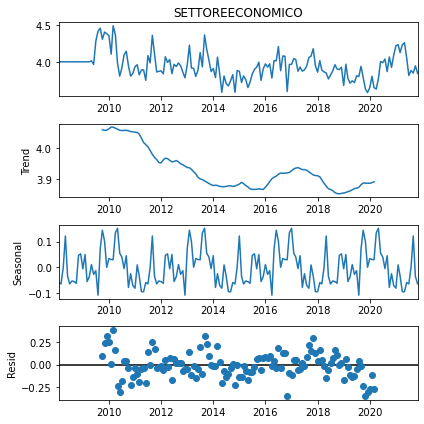

In [145]:
plt.rcParams.update({'figure.figsize': (6,6)})
result_add = seasonal_decompose(Dismissals_Milano['SETTOREECONOMICO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

## Stationarity

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

In [146]:
# ADF calculation
p_value(Dismissals_Milano["SETTOREECONOMICO"])

ADF Statistic: -4.598997
p-value: 0.000130


### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

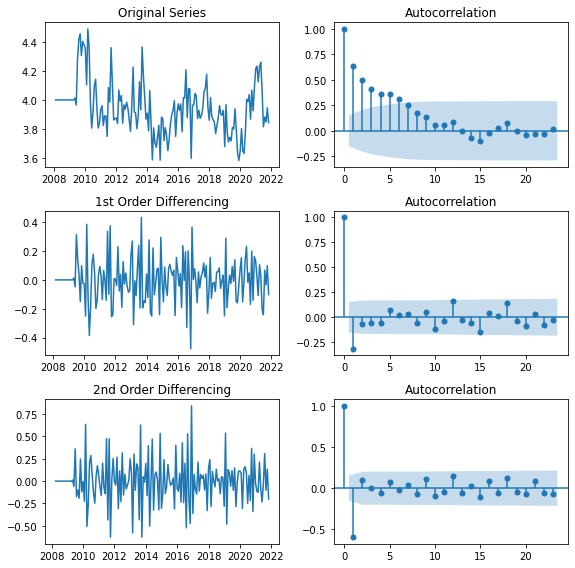

In [147]:
# Differencing plots representation
Differencing_Plot(Dismissals_Milano["SETTOREECONOMICO"])

In [148]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Dismissals_Milano["SETTOREECONOMICO"].diff())

ADF Statistic: -9.514676
p-value: 0.000000


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

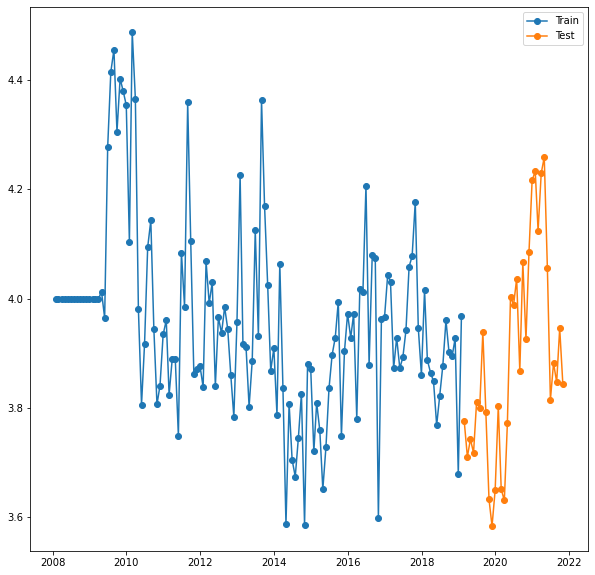

In [149]:
train, test = Dynamic_Splitting(Dismissals_Milano,"SETTOREECONOMICO",0.8)

## SARIMAX Model Implementation

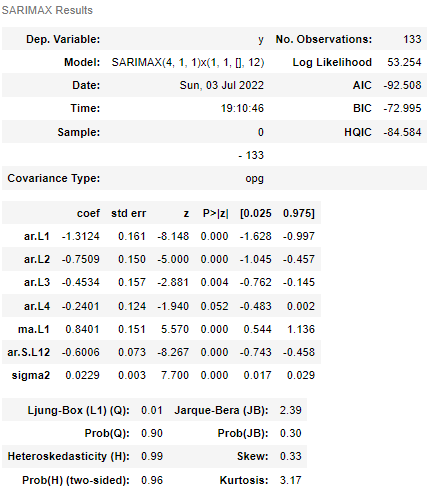

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [150]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-27.111, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-85.853, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-45.110, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-85.961, Time=0.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-69.054, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-90.675, Time=0.27 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-90.668, Time=0.17 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-90.984, Time=0.37 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-90.716, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  133
Model:             SARIMAX(4, 1, 1)x(1, 1, [], 12)   Log Likelihood                  53.254
Date:                             Wed, 06 Jul 2022   AIC                            -92.508
Time:                                     10:39:55   BIC                            -72.995
Sample:                                          0   HQIC                           -84.584
                                             - 133                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3122      0.161     -8.141      0.000      -1.628      -0.996
ar.L2         -0.7508      0.150     -4.999      0.000      -1.045      -0.456
ar.L3         -0.4534      0.157     -2.881      0.004      -0.762      -0.145
ar.L4         -0.2401      0.124     -1.940      0.052      -0.483       0.002
ma.L1          0.8399      0.151      5.564      0.000       0.544       1.136
ar.S.L12      -0.6006      0.073     -8.267      0.000      -0.743      -0.458
sigma2         0.0229      0.003      7.700      0.000       0.017       0.029
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.39
Prob(Q):                              0.90   Prob(JB):                         0.30
Heteroskedasticity (H):               0.99   Skew:                             0.33
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


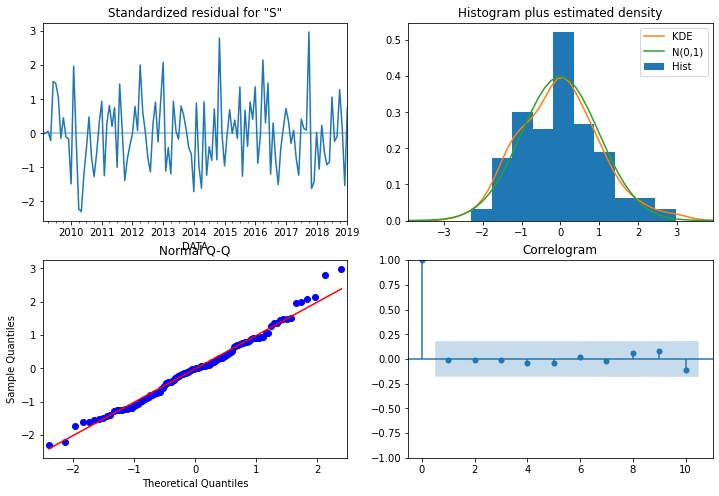

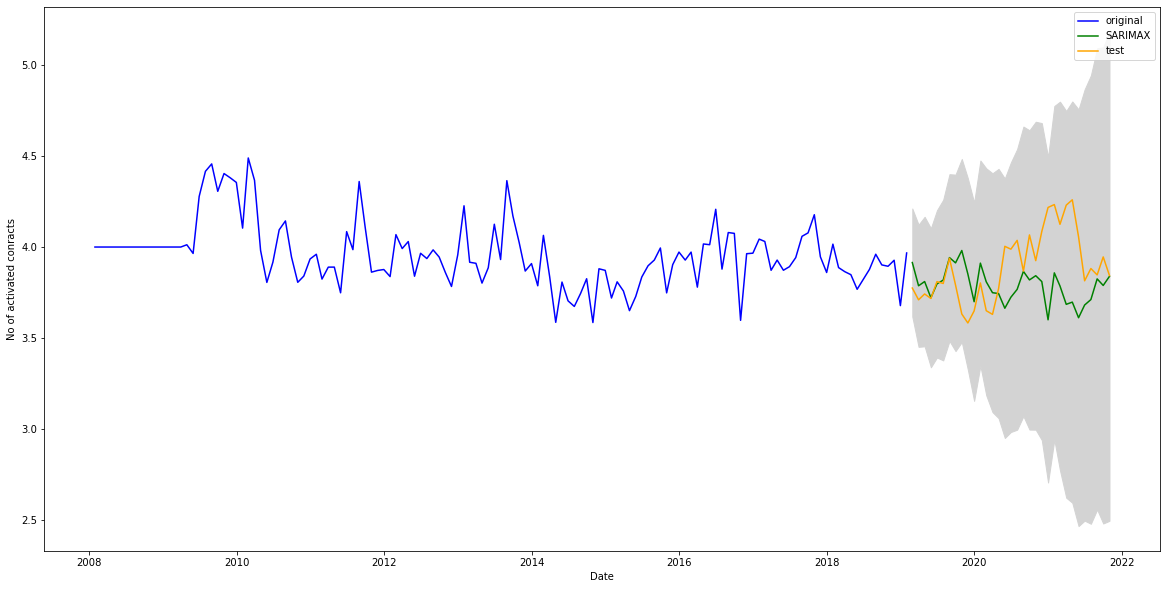

In [151]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"SETTOREECONOMICO",33,4,1,1,1,1,0,12)

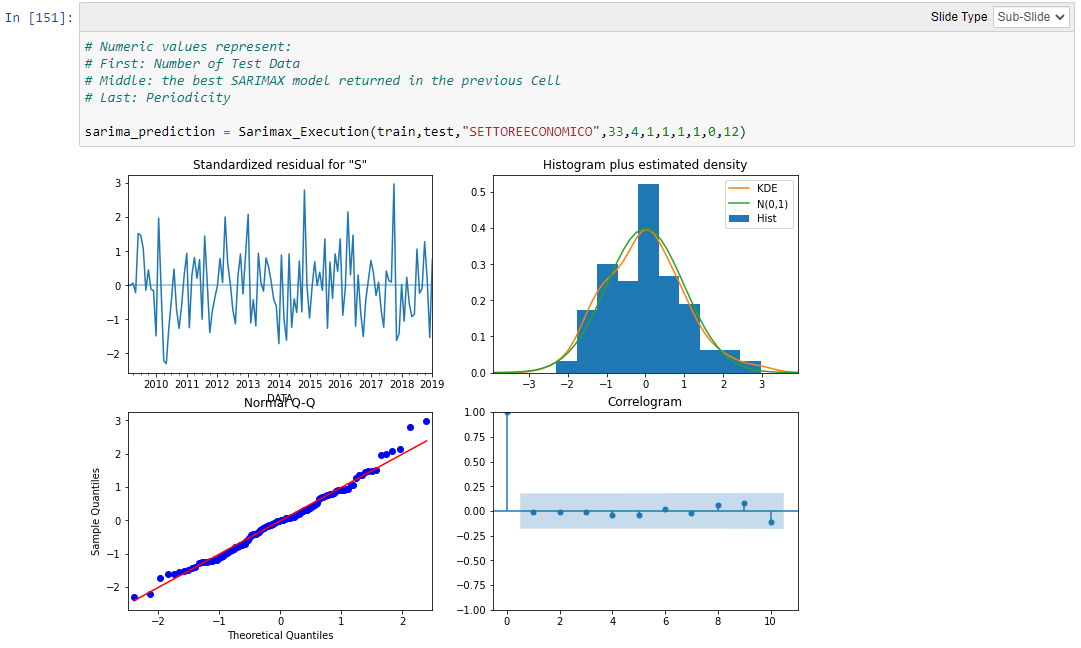

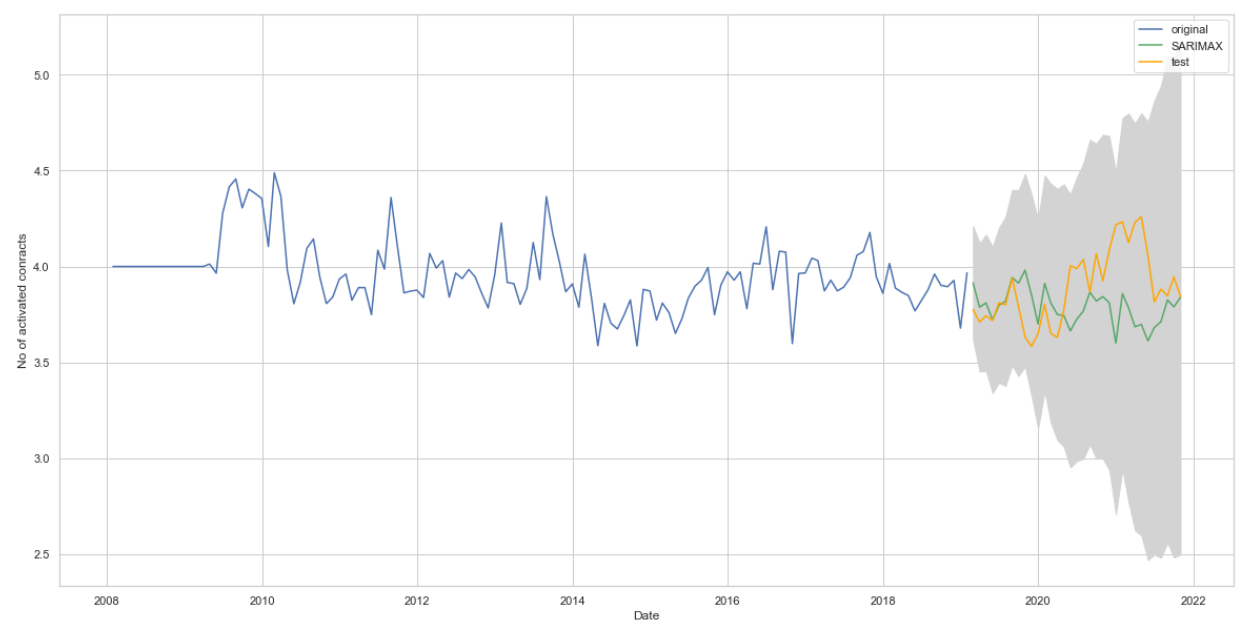

In [152]:
# Metrics of Sarima Evaluation
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 0.258718


## LSTM Forecasting

LSTM allows to predict the future values of a Time Serie adopting a Machine Learning approach

Before to start Training and Testing data are scaled. Here the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

In [153]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [154]:
Dismissals_Milano.head(), Dismissals_Milano.tail()

(            SETTOREECONOMICO
 DATA                        
 2008-01-31               4.0
 2008-02-29               4.0
 2008-03-31               4.0
 2008-04-30               4.0
 2008-05-31               4.0,
             SETTOREECONOMICO
 DATA                        
 2021-06-30          3.814750
 2021-07-31          3.882065
 2021-08-31          3.847076
 2021-09-30          3.945666
 2021-10-31          3.843613)

In [155]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [156]:
# Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [157]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.45881453 0.45881453 0.45881453 0.45881453 0.45881453 0.45881453
 0.45881453 0.45881453 0.45881453 0.45881453 0.45881453 0.45881453]
Prediction: 
[[0.45881453]]


In [158]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [159]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [160]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.fit(generator, epochs = 130)  #Epochs = Number of Iterations

Epoch 1/130
121/121 [==============================] - 1s 3ms/step - loss: 0.0444
Epoch 2/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0351
Epoch 3/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0313
Epoch 4/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 5/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0322
Epoch 6/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0316
Epoch 7/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0296
Epoch 8/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0301
Epoch 9/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 10/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 11/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0290
Epoch 12/130
121/121 [==============================] - 0s 4ms/step - loss: 0.0277
Epoch 13/130


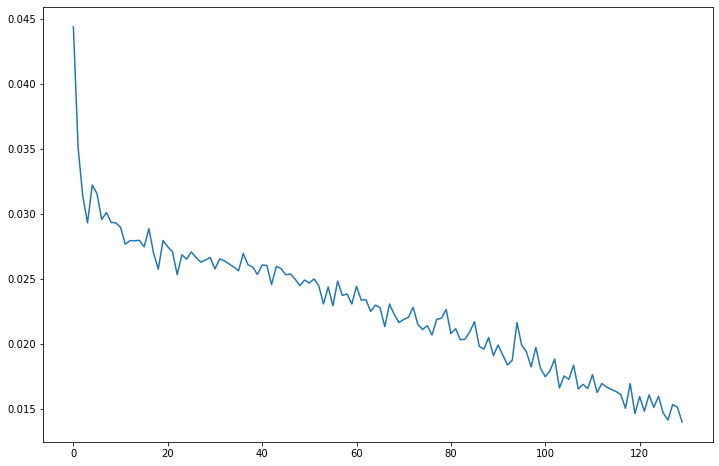

In [162]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [163]:
last_train_batch = scaled_train[-12:]

In [164]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [165]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 161ms/step


array([[0.4773725]], dtype=float32)

In [166]:
scaled_test[0]

array([0.20969665])

In [167]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 20ms/step


In [168]:
test_predictions

[array([0.4773725], dtype=float32),
 array([0.47055724], dtype=float32),
 array([0.37956485], dtype=float32),
 array([0.2547534], dtype=float32),
 array([0.26487917], dtype=float32),
 array([0.33681065], dtype=float32),
 array([0.4828847], dtype=float32),
 array([0.6145301], dtype=float32),
 array([0.71716195], dtype=float32),
 array([0.5881996], dtype=float32),
 array([0.34431016], dtype=float32),
 array([0.35376844], dtype=float32),
 array([0.44827202], dtype=float32),
 array([0.4742932], dtype=float32),
 array([0.34495413], dtype=float32),
 array([0.25384405], dtype=float32),
 array([0.23915488], dtype=float32),
 array([0.29492766], dtype=float32),
 array([0.35679242], dtype=float32),
 array([0.36201087], dtype=float32),
 array([0.31773925], dtype=float32),
 array([0.28972438], dtype=float32),
 array([0.27930567], dtype=float32),
 array([0.35287318], dtype=float32),
 array([0.5349628], dtype=float32),
 array([0.6815157], dtype=float32),
 array([0.62691367], dtype=float32),
 array([0

In [169]:
test.head()

SETTOREECONOMICO
DATA                        
2019-02-28          3.775063
2019-03-31          3.710389
2019-04-30          3.742467
2019-05-31          3.717795
2019-06-30          3.810248

In [170]:
true_predictions= scaler.inverse_transform(test_predictions)

In [171]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_15400/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [172]:
test.head()

SETTOREECONOMICO  Predictions
DATA                                     
2019-02-28          3.775063     4.016757
2019-03-31          3.710389     4.010603
2019-04-30          3.742467     3.928443
2019-05-31          3.717795     3.815746
2019-06-30          3.810248     3.824889

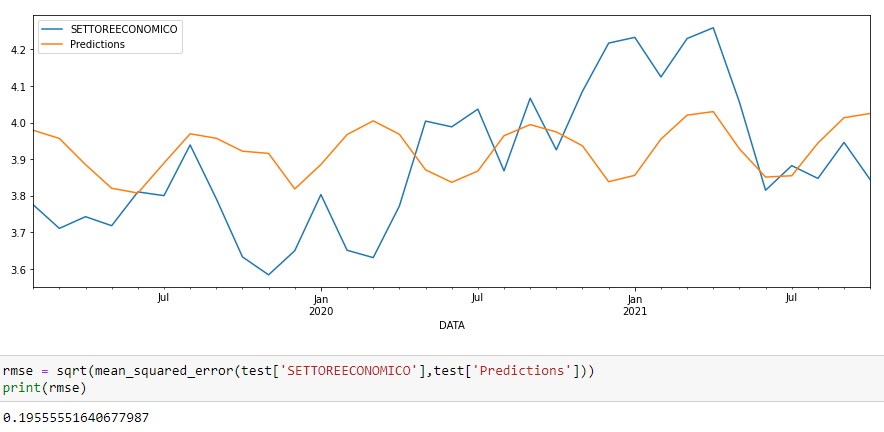

<AxesSubplot:xlabel='DATA'>

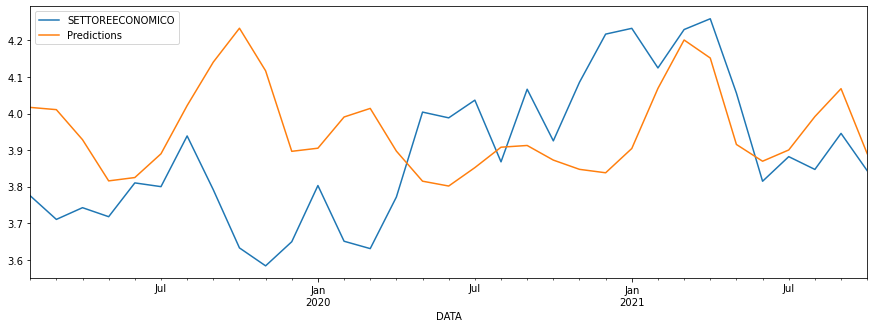

In [173]:
test.plot(figsize = (15,5))

In [174]:
rmse = sqrt(mean_squared_error(test['SETTOREECONOMICO'],test['Predictions']))
print(rmse)

0.23631396936800608


In [175]:
################################################################################################################################

# Function Definition_Sondrio_Fired

In [176]:
# Dynamic function to divide Dataset into testing and training set 
def Dynamic_Splitting (parDf,parColumn,parTrainSize):
    
    # Test e Train DataSet creation
    train_size = parTrainSize
    split_idx = round(len(Dismissals_Sondrio["SETTOREECONOMICO"])* train_size)

    # Split
    train = Dismissals_Sondrio.iloc[:split_idx]
    test = Dismissals_Sondrio.iloc[split_idx:]
    

    # Visualize split
    fig,ax= plt.subplots(figsize=(10,10))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train, test

In [177]:
################################################################################################################################

# TimeSeries_Fired_Sondrio

# Creation of the New DataSet for Time Serie

In [178]:
Dismissals = pd.read_csv('Lavori_Cessati_Cleaning.csv')

In [179]:
Dismissals_Sondrio = Dismissals.copy()

## Changing Columns Type

In [180]:
Dismissals_Sondrio['DATA'] = pd.to_datetime(Dismissals_Sondrio['DATA'])
Dismissals_Sondrio['SETTOREECONOMICO'] = pd.to_numeric(Dismissals_Sondrio['SETTOREECONOMICO'])

In [181]:
Dismissals_Sondrio.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
TIPO                                 object
NAZIONE                              object
ANNO                                  int64
SETTOREECONOMICO                      int64
dtype: object

In [182]:
Dismissals_Sondrio.PROVINCIAIMPRESA.unique()

array(['MILANO', 'SONDRIO'], dtype=object)

## Rebuilding of the DataSet

In [183]:
Dismissals_Sondrio = Dismissals_Sondrio[['DATA', 'SETTOREECONOMICODETTAGLIO', 'SETTOREECONOMICO', 'PROVINCIAIMPRESA']]
Dismissals_Sondrio.head()

DATA                          SETTOREECONOMICODETTAGLIO  \
0 2021-03-11  Attività di famiglie e convivenze come datori ...   
1 2021-05-03  Costruzione di edifici residenziali e non resi...   
2 2021-05-12  Costruzione di edifici residenziali e non resi...   
3 2019-04-08                  Ristorazione con somministrazione   
4 2020-12-04  Attività di famiglie e convivenze come datori ...   

   SETTOREECONOMICO PROVINCIAIMPRESA  
0                 4           MILANO  
1                 7           MILANO  
2                 7           MILANO  
3                 2           MILANO  
4                 4           MILANO

In [184]:
Dismissals_Sondrio = Dismissals_Sondrio[Dismissals_Sondrio['PROVINCIAIMPRESA'] == 'SONDRIO']

In [185]:
Dismissals_Sondrio = Dismissals_Sondrio.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [186]:
Dismissals_Sondrio.head()

SETTOREECONOMICO
DATA                        
2008-01-31               4.0
2008-02-29               2.0
2008-03-31               4.0
2008-04-30               4.0
2008-05-31               4.0

# TimeSeries Fired Sondrio

<AxesSubplot:xlabel='DATA'>

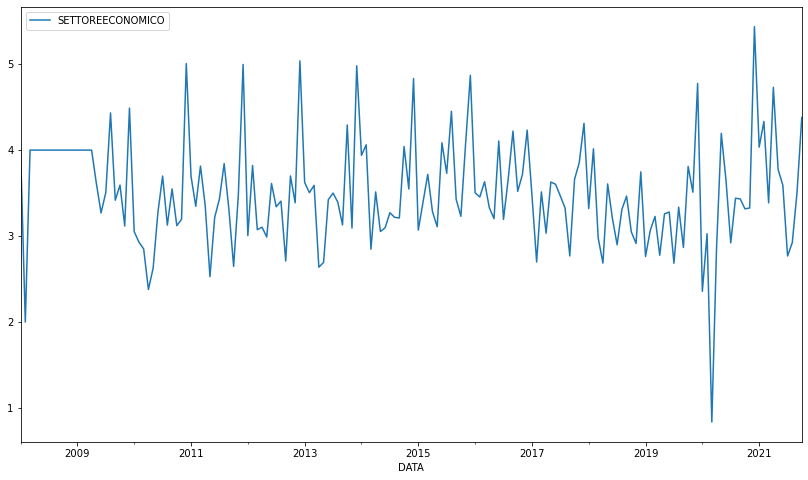

In [187]:
Dismissals_Sondrio.plot(figsize=(14,8))

## Seasonality

### Multiplicative Seasonal Decompose

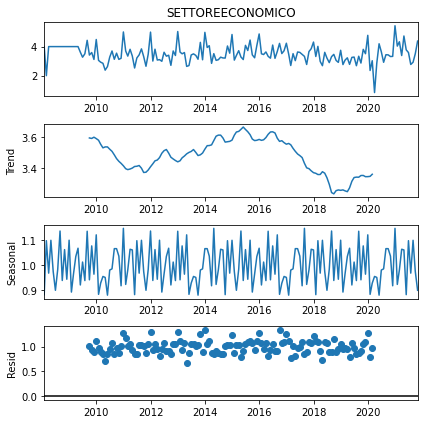

In [188]:
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul = seasonal_decompose(Dismissals_Sondrio['SETTOREECONOMICO'], model = 'multiplicative', period = 40)
decomposition_result = result_mul.plot()

### Additive Seasonal Decompose

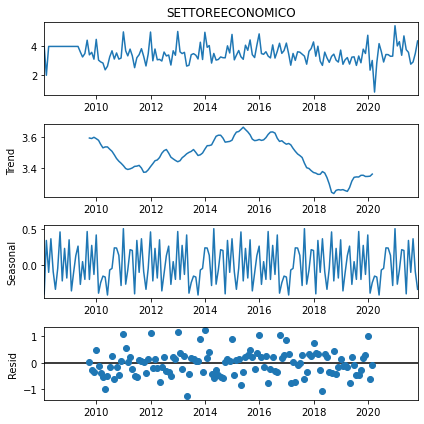

In [189]:
plt.rcParams.update({'figure.figsize': (6,6)})
result_add = seasonal_decompose(Dismissals_Sondrio['SETTOREECONOMICO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

## Stationarity

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

In [190]:
# ADF calculation
p_value(Dismissals_Sondrio["SETTOREECONOMICO"])

ADF Statistic: -2.681031
p-value: 0.077379


### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

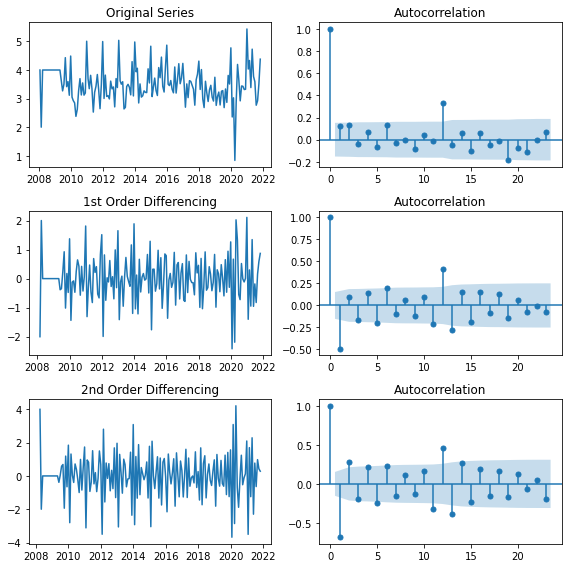

In [191]:
# Differencing plots representation
Differencing_Plot(Dismissals_Sondrio["SETTOREECONOMICO"])

In [192]:
# Verifying if the Time Serie has become Stationary (If p_value < 0.05)
p_value(Dismissals_Sondrio["SETTOREECONOMICO"].diff())

ADF Statistic: -6.233931
p-value: 0.000000


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

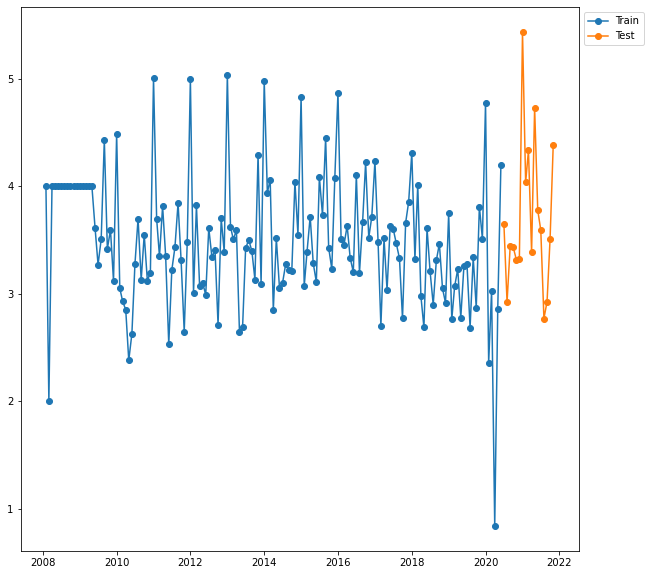

In [193]:
train, test = Dynamic_Splitting(Dismissals_Sondrio,"SETTOREECONOMICO",0.90)

## SARIMAX Model Creation

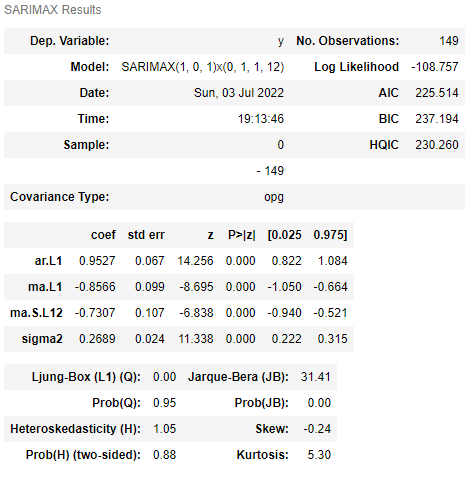

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [194]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=227.453, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=262.737, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=232.828, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=227.423, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=262.079, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=263.244, Time=0.06 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=229.376, Time=0.47 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=229.393, Time=0.60 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=233.003, Time=0.18 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=230.756, Time=1.46 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=225.724, Time=0.61 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=264.767, Time=0.25 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=227.279, Time=1.00 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=227.443, Time=1.25 sec
 ARIMA(1,0,1)(1,1,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  149
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -108.757
Date:                            Wed, 06 Jul 2022   AIC                            225.514
Time:                                    10:41:28   BIC                            237.194
Sample:                                         0   HQIC                           230.260
                                            - 149                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9526      0.067     14.249      0.000       0.822       1.084
ma.L1         -0.8566      0.099     -8.691      0.000      -1.050      -0.663
ma.S.L12      -0.7307      0.107     -6.838      0.000      -0.940      -0.521
sigma2         0.2689      0.024     11.338      0.000       0.222       0.315
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.41
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.24
Prob(H) (two-sided):                  0.88   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


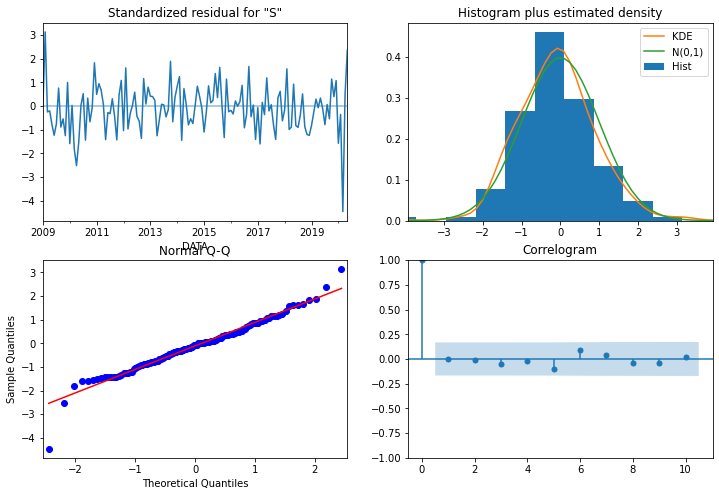

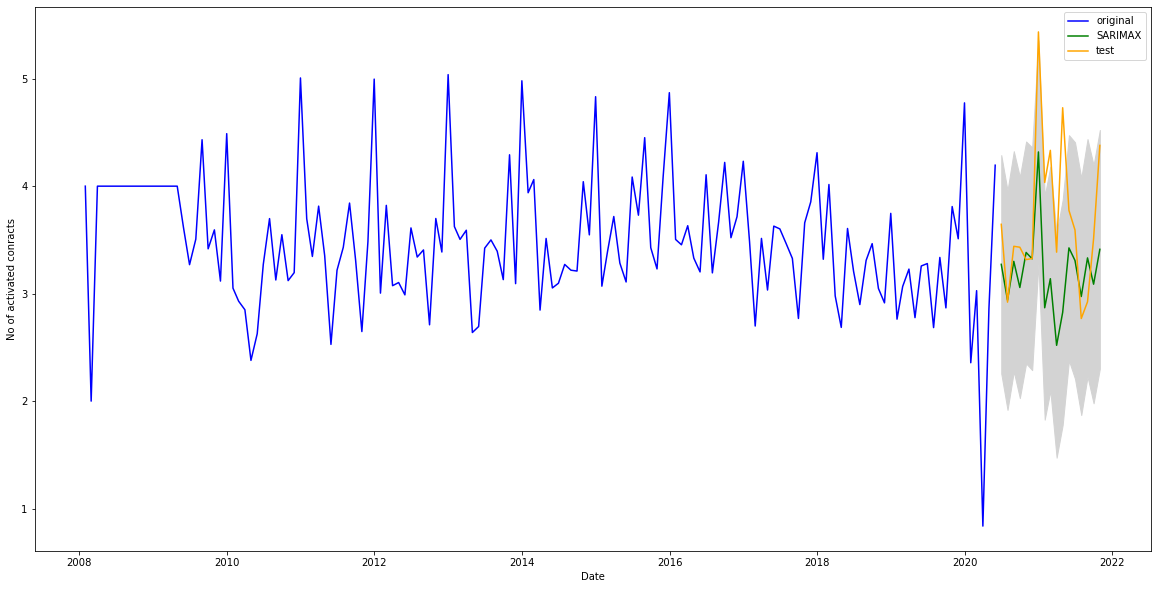

In [195]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"SETTOREECONOMICO",17,1,0,1,0,1,1,12)

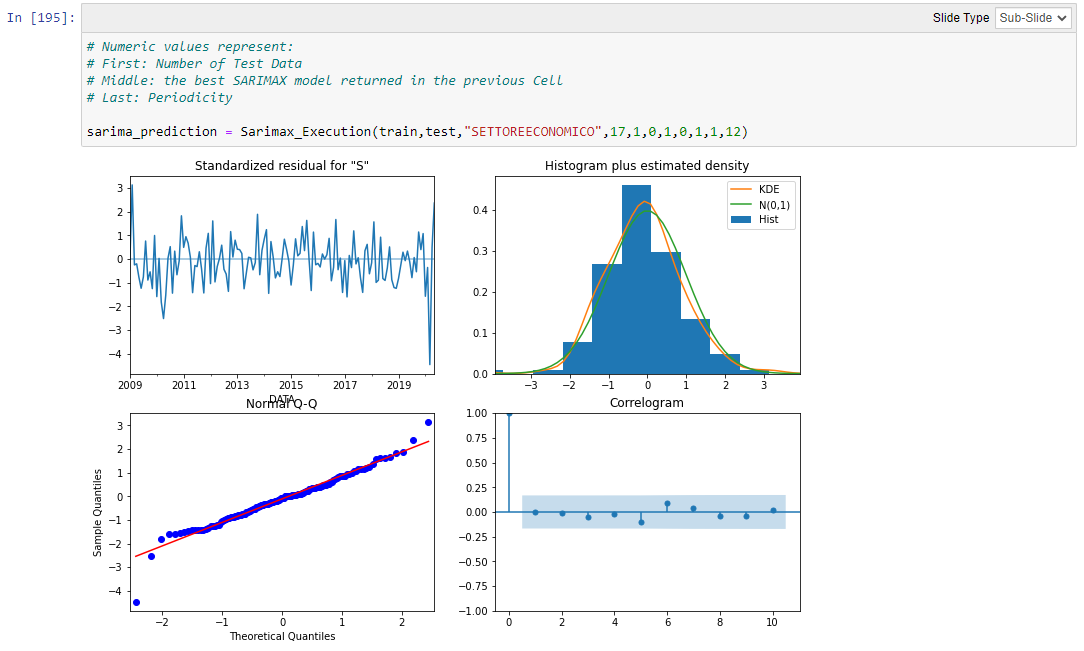

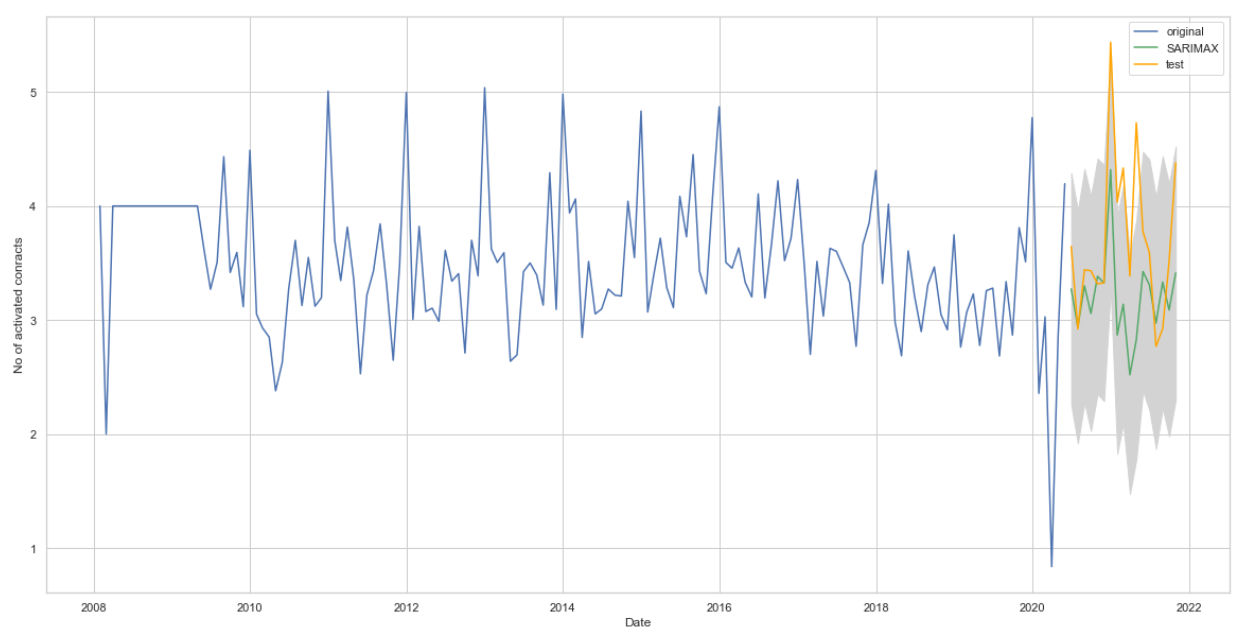

In [196]:
# Valutation Metrics of Sarima
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 0.775980


## LSTM Forecasting

LSTM allows to predict the future values of a Time Serie adopting a Machine Learning approach

Before to start Training and Testing data are scaled. Here the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

In [197]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [198]:
Dismissals_Sondrio.head(), Dismissals_Sondrio.tail()

(            SETTOREECONOMICO
 DATA                        
 2008-01-31               4.0
 2008-02-29               2.0
 2008-03-31               4.0
 2008-04-30               4.0
 2008-05-31               4.0,
             SETTOREECONOMICO
 DATA                        
 2021-06-30          3.591837
 2021-07-31          2.768595
 2021-08-31          2.924370
 2021-09-30          3.510638
 2021-10-31          4.379310)

In [199]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [200]:
# Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [201]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.75293373 0.27680601 0.75293373 0.75293373 0.75293373 0.75293373
 0.75293373 0.75293373 0.75293373 0.75293373 0.75293373 0.75293373]
Prediction: 
[[0.75293373]]


In [202]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [204]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [205]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [206]:
model.fit(generator, epochs = 180)  #Epochs = Number of Iterations

Epoch 1/180
137/137 [==============================] - 2s 4ms/step - loss: 0.0608
Epoch 2/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0241
Epoch 3/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0222
Epoch 4/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0233
Epoch 5/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0224
Epoch 6/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0225
Epoch 7/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0220
Epoch 8/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0213
Epoch 9/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0217
Epoch 10/180
137/137 [==============================] - 1s 4ms/step - loss: 0.0210
Epoch 11/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0223
Epoch 12/180
137/137 [==============================] - 1s 5ms/step - loss: 0.0214
Epoch 13/180


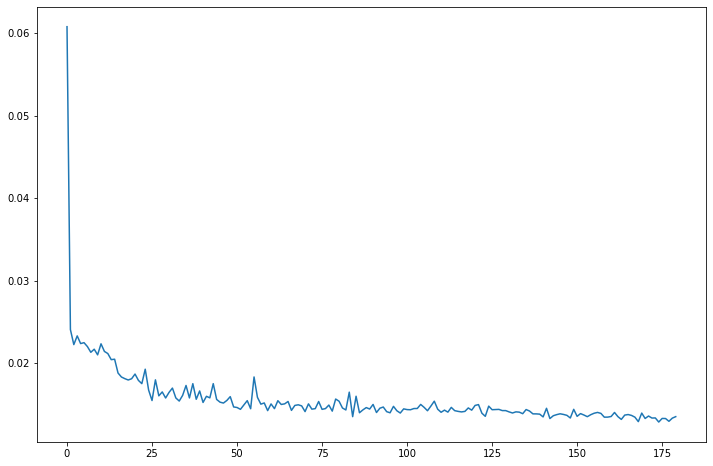

In [207]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [208]:
last_train_batch = scaled_train[-12:]

In [209]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [210]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 130ms/step


array([[0.8357855]], dtype=float32)

In [211]:
scaled_test[0]

array([0.66845946])

In [212]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 17ms/step


In [213]:
test_predictions

[array([0.8357855], dtype=float32),
 array([0.94405866], dtype=float32),
 array([0.97139597], dtype=float32),
 array([1.0621936], dtype=float32),
 array([1.078147], dtype=float32),
 array([1.1923234], dtype=float32),
 array([1.2119853], dtype=float32),
 array([1.0335513], dtype=float32),
 array([1.0298576], dtype=float32),
 array([0.92864174], dtype=float32),
 array([0.70278895], dtype=float32),
 array([0.7327929], dtype=float32),
 array([0.76068217], dtype=float32),
 array([0.878484], dtype=float32),
 array([0.9010567], dtype=float32),
 array([0.97701997], dtype=float32),
 array([0.97717685], dtype=float32)]

In [214]:
test.head()

SETTOREECONOMICO
DATA                        
2020-06-30          3.645161
2020-07-31          2.920792
2020-08-31          3.440476
2020-09-30          3.432000
2020-10-31          3.316832

In [215]:
true_predictions= scaler.inverse_transform(test_predictions)

In [216]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_15400/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [217]:
test.head()

SETTOREECONOMICO  Predictions
DATA                                     
2020-06-30          3.645161     4.348023
2020-07-31          2.920792     4.802831
2020-08-31          3.440476     4.917662
2020-09-30          3.432000     5.299063
2020-10-31          3.316832     5.366076

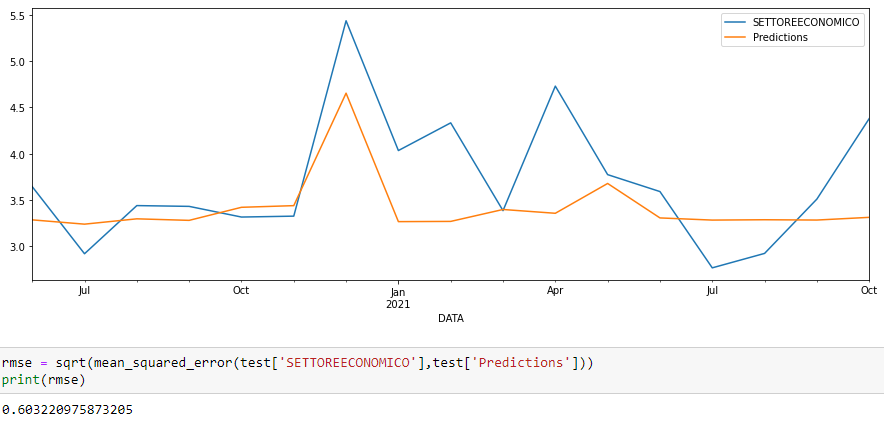

<AxesSubplot:xlabel='DATA'>

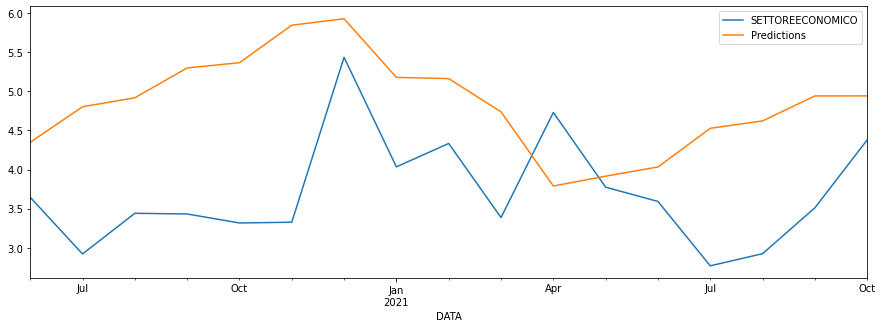

In [218]:
test.plot(figsize = (15,5))

In [219]:
rmse = sqrt(mean_squared_error(test['SETTOREECONOMICO'],test['Predictions']))
print(rmse)

1.409140020482168


# Conclusions

In the project we studied the change in hiring and layoffs in the nine economic sectors that recorded the highest number of employees. Analyzing the results it emerged that the LSTM model is able to return slightly more accurate predictions than the Sarimax statistical model. The first, being a Machine Learning model, learns and continuously evolves with each program execution and provides very precise forecasts in the case of seasonal time series as emerged from the data regarding the data assumptions of the province of Sondrio. However, it has difficulty in forecasting time series containing too high ranges of values, as it cannot predict sudden spikes in values ​​that our time series sometimes have.